# Projet 10 : Détectez des faux billets avec R ou Python

## Objectifs de la présentation

## Mettre en place une modélisation qui sérait capable d'identifier automatiquement les vraies des faux billets
### 1. Une analyse descriptive des données, la régression lineaire 
### 2. Mettre en concurrence 2 méthodes de prédiction : 
### a.) Une régression logistique classique
### b.) Un K-Means, duquel seront utilisés les centroïdes pour réaliser la prédiction
### 3. Des matrices de confusion pour des évaluations optimales des modèles 

## 1. L'analyse descriptive des données

In [201]:
#Importer des librairies
import pandas as pd
import numpy as np
import pylab as pl
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
import matplotlib.pyplot as plt  
import seaborn as sns

In [202]:
#Charger les données
df_billet=pd.read_csv("billets.csv", sep =';')

In [203]:
#Afficher les 6 premier lignes
df_billet.head(6)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.810,104.860,104.950,4.520,2.890,112.830
1,True,171.460,103.360,103.660,3.770,2.990,113.090
2,True,172.690,104.480,103.500,4.400,2.940,113.160
3,True,171.360,103.910,103.940,3.620,3.010,113.510
4,True,171.730,104.280,103.460,4.040,3.480,112.540
5,True,172.170,103.740,104.080,4.420,2.950,112.810


#### Dimensions géométriques
Il y a actuellement de six informations géométriques sur un billet :
- length : la longueur du billet (en mm) ;
- height_left : la hauteur du billet (mesurée sur le côté gauche, en
mm) ;
- height_right : la hauteur du billet (mesurée sur le côté droit, en mm) ;
- margin_up : la marge entre le bord supérieur du billet et l'image de
celui-ci (en mm) ;
- margin_low : la marge entre le bord inférieur du billet et l'image de
celui-ci (en mm) ;
- diagonal : la diagonale du billet (en mm).

In [204]:
#Afficher l'ensemble des informations sur des données; des colonnes, des non-valeurs manquantes, et des types
df_billet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [205]:
#Sélectionner des keys
df_billet.keys()

Index(['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low',
       'margin_up', 'length'],
      dtype='object')

In [206]:
#Vérifier s'il y des valeurs manquantes dans l'ensemble de DataFrame
df_billet.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [207]:
#Afficher des lignes avec des valeurs manquantes 
print(df_billet[df_billet['margin_low'].isnull()])

      is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72          True   171.940      103.890       103.450         NaN      3.250   
99          True   171.930      104.070       104.180         NaN      3.140   
151         True   172.070      103.800       104.380         NaN      3.020   
197         True   171.450      103.660       103.800         NaN      3.620   
241         True   171.830      104.140       104.060         NaN      3.020   
251         True   171.800      103.260       102.820         NaN      2.950   
284         True   171.920      103.830       103.760         NaN      3.230   
334         True   171.850      103.700       103.960         NaN      3.000   
410         True   172.560      103.720       103.510         NaN      3.120   
413         True   172.300      103.660       103.500         NaN      3.160   
445         True   172.340      104.420       103.220         NaN      3.010   
481         True   171.810      103.530 

In [208]:
#Faire une rapide inspection de données (statistiques)
df_billet.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000,1500.000,1500.000,1463.000,1500.000,1500.000
mean,171.958,104.030,103.920,4.486,3.151,112.679
std,0.305,0.299,0.326,0.664,0.232,0.873
min,171.040,103.140,102.820,2.980,2.270,109.490
25%,171.750,103.820,103.710,4.015,2.990,112.030
50%,171.960,104.040,103.920,4.310,3.140,112.960
75%,172.170,104.230,104.150,4.870,3.310,113.340
max,173.010,104.880,104.950,6.900,3.910,114.440


In [209]:
#Vérifier s'il exist des données dupliquées
df_billet.duplicated().sum()

0

In [210]:
#Afficher de nombre des lignes différentes dans chaque colonnes
df_billet.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [211]:
#Afficher des valeurs de colonne 'is_genuine' 
df_billet['is_genuine']

0        True
1        True
2        True
3        True
4        True
        ...  
1495    False
1496    False
1497    False
1498    False
1499    False
Name: is_genuine, Length: 1500, dtype: bool

In [212]:
#Constater qu'il n' y a pas de ligne dupliquée dans colonne 'is_genuine'
df_billet.drop(columns='is_genuine').duplicated().sum()

0

In [213]:
#Convetir la colonne 'is_genuine' en un type de données catégoriel pour gérer les variables catégorielles 
df_billet['is_genuine'] = df_billet['is_genuine'].astype('category')
print(df_billet['is_genuine'],'\n')
print(df_billet['is_genuine'].info())

0        True
1        True
2        True
3        True
4        True
        ...  
1495    False
1496    False
1497    False
1498    False
1499    False
Name: is_genuine, Length: 1500, dtype: category
Categories (2, object): [False, True] 

<class 'pandas.core.series.Series'>
RangeIndex: 1500 entries, 0 to 1499
Series name: is_genuine
Non-Null Count  Dtype   
--------------  -----   
1500 non-null   category
dtypes: category(1)
memory usage: 1.7 KB
None


In [214]:
#Encoder les catégories de la colonne en valeurs numériques
df_billet["is_genuine"].cat.codes

0       1
1       1
2       1
3       1
4       1
       ..
1495    0
1496    0
1497    0
1498    0
1499    0
Length: 1500, dtype: int8

In [215]:
#Déterminer des proportion de colonne 'is_genuine'
df_billet.iloc[:, 0].value_counts(normalize=True).round(2)

True    0.670
False   0.330
Name: is_genuine, dtype: float64

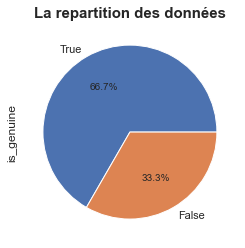

In [216]:
#Visualiser des données par un graphique de type camembert
df_billet.iloc[:, 0].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('La repartition des données',fontsize=15, fontweight='bold')
plt.show()

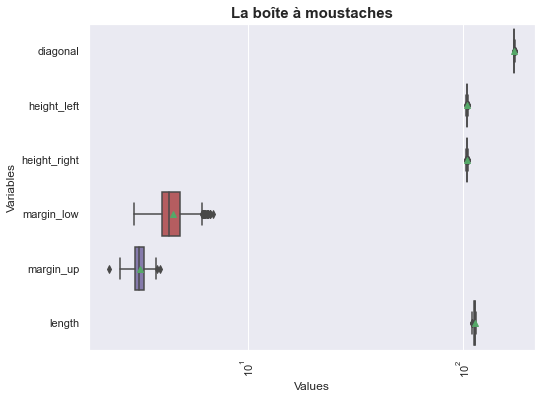

In [217]:
#La distribution des données
plt.figure(figsize=(8,6))
sns.boxplot(data=df_billet,orient="h",showmeans=True)
plt.title("La boîte à moustaches", fontsize=15, fontweight='bold')
plt.ylabel("Variables",loc='center')
plt.xlabel("Values")
plt.ylim()
plt.xscale('log')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

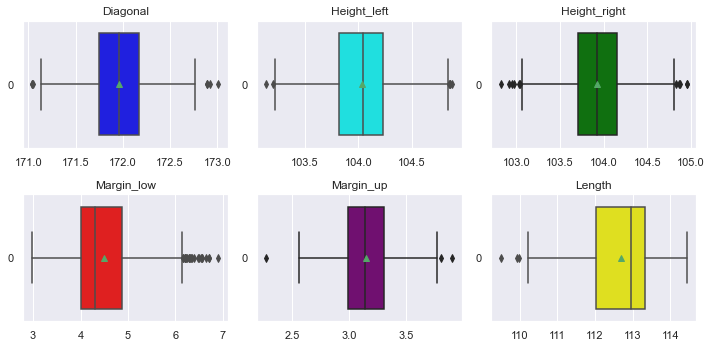

In [218]:
#Faire de boîte aux moustaches pour chaque colonne
plt.figure(figsize=(10, 5))
sns.set(style="darkgrid")

#Définir les nombres des colonnes et lignes des subplots 
nrow=2
ncol=3

plt.subplot(231)
sns.boxplot(data=df_billet['diagonal'],orient="h",color='blue', showmeans=True)
plt.title('Diagonal')

plt.subplot(232)
sns.boxplot(data=df_billet['height_left'],orient="h",color='cyan', showmeans=True)
plt.title('Height_left')

plt.subplot(233)
sns.boxplot(data=df_billet['height_right'],orient="h",color='green', showmeans=True)
plt.title('Height_right')

plt.subplot(234)
sns.boxplot(data=df_billet['margin_low'],orient="h",color='red',showmeans=True)
plt.title('Margin_low')

plt.subplot(235)
sns.boxplot(data=df_billet['margin_up'],orient="h",color='purple',showmeans=True)
plt.title('Margin_up')

plt.subplot(236)
sns.boxplot(data=df_billet['length'],orient="h",color='yellow',showmeans=True)
plt.title('Length')
plt.tight_layout()
plt.show()

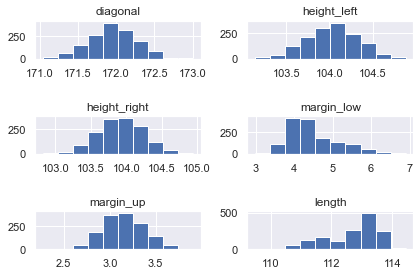

In [219]:
#Créer des histogrammes pour toutes les colonnes sélectionnées
df_billet.hist() 
plt.tight_layout(h_pad=2)
plt.show() 

Diagonal


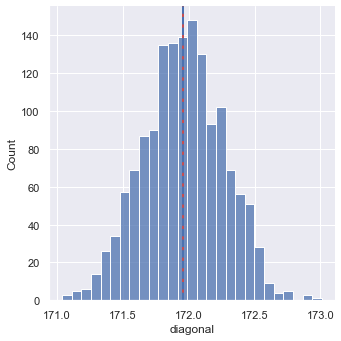

Skewness:  -0.03327338562637491
Kurtosis:  -0.1288643638667306
KstestResult(statistic=0.045, pvalue=0.17231138650045252) 

Height_left


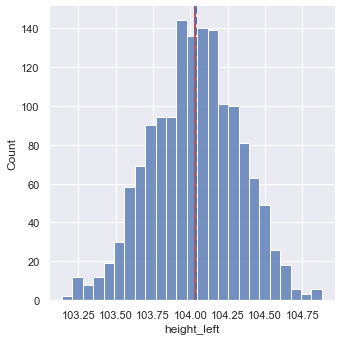

Skewness:  -0.09202848000665637
Kurtosis:  -0.19861842156870724
KstestResult(statistic=0.033666666666666664, pvalue=0.4972303973263551) 

Height_right


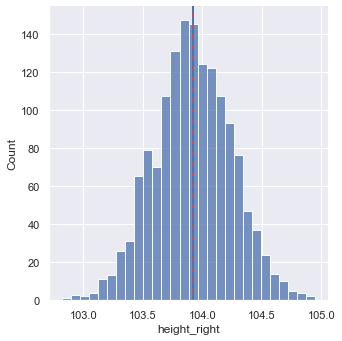

Skewness:  -0.000327219556341104
Kurtosis:  -0.031138318138161925
KstestResult(statistic=0.034, pvalue=0.48449676876654035) 

Margin_low


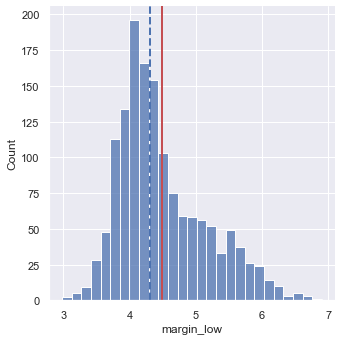

Skewness:  nan
Kurtosis:  nan
KstestResult(statistic=0.08966666666666667, pvalue=0.0001226398190248279) 

Margin_up


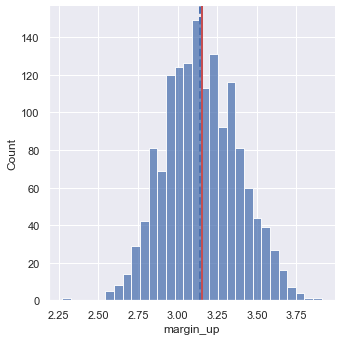

Skewness:  0.1457918478253625
Kurtosis:  -0.248256984444303
KstestResult(statistic=0.042333333333333334, pvalue=0.22797661987542406) 

Length


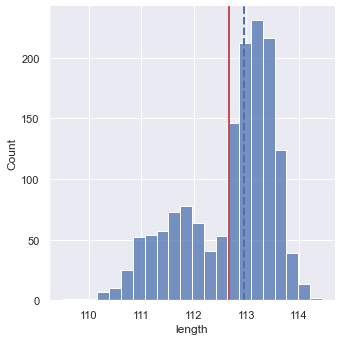

Skewness:  -0.8151403548537486
Kurtosis:  -0.28338839609225497
KstestResult(statistic=0.14733333333333334, pvalue=8.335554468885675e-12) 



In [220]:
#Importer des relevantes librairies pour Kolmogorov-Smirnov test
import scipy as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ks_2samp

plt.rcParams.update({'font.size':15})
def distrib_normalize(i):

    print(i.capitalize())
    _ = sns.displot(df_billet[i])
    _ = plt.axvline(x=df_billet[i].mean(), label='Moyenne', linestyle='-', color='r', linewidth=2)
    _ = plt.axvline(x=df_billet[i].median(), label='Médiane', linestyle='--', color='b', linewidth=2)
    _ = plt.show()
    print('Skewness: ', str(st.stats.skew(df_billet[i])))
    print('Kurtosis: ', str(st.stats.kurtosis(df_billet[i])))
    print((str(ks_2samp(df_billet[i],list(np.random.normal(np.mean(df_billet[i]), np.std(df_billet[i]), 1000))))),'\n')

cols = df_billet[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]

for i in cols:
    distrib_normalize(i)
    

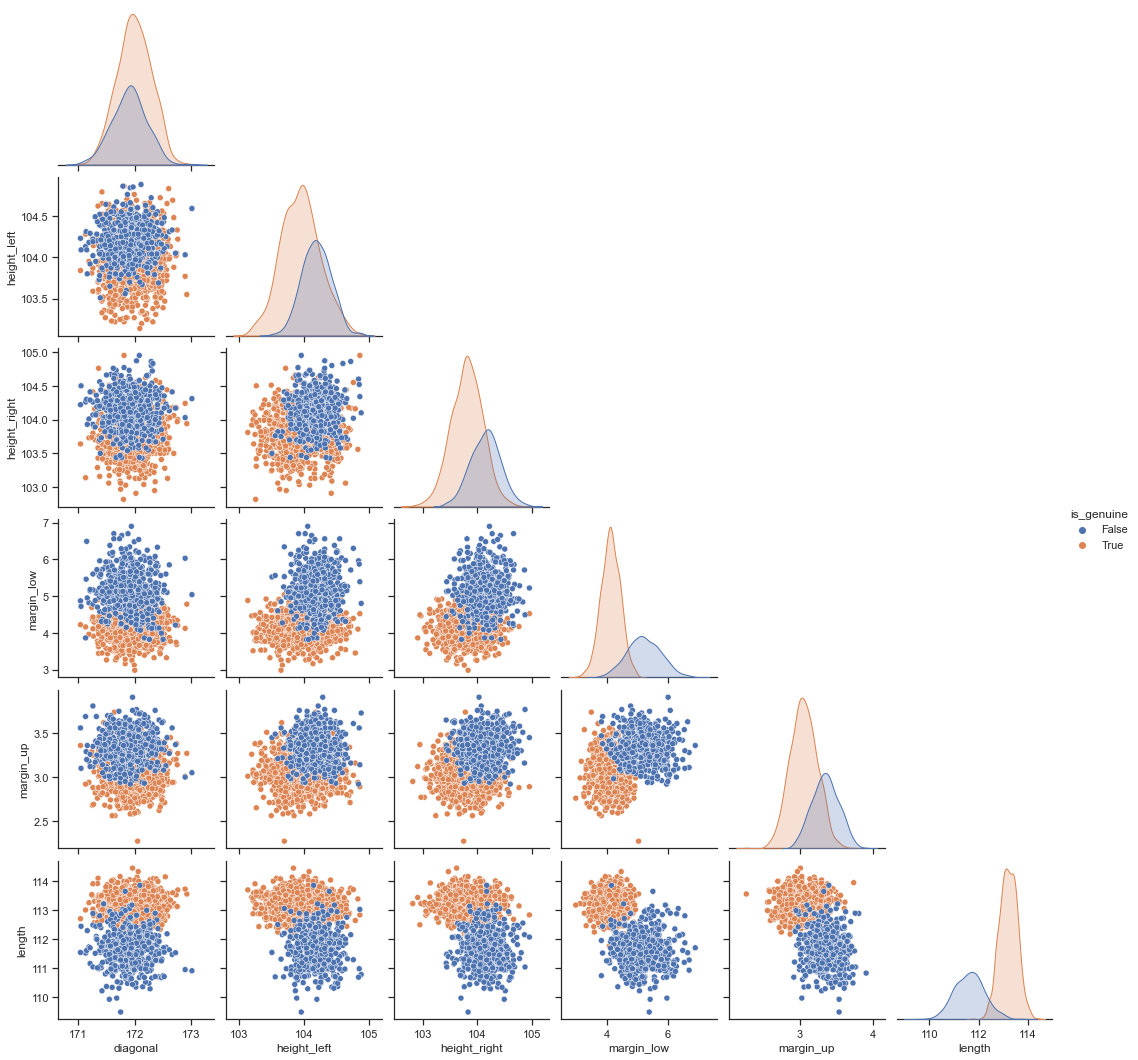

In [221]:
#Exploration des données via les graphiques
import seaborn as sns
sns.set_theme(style='ticks')
df=df_billet
sns.pairplot(df,hue='is_genuine',corner=True)
plt.show()

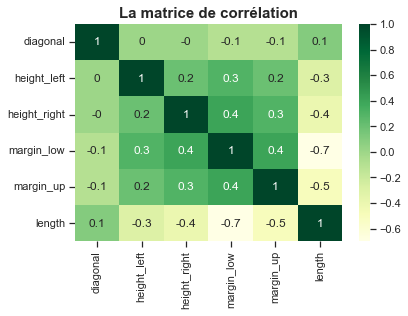

In [222]:
#Etude de la correlation
matrice_corr = df_billet.corr().round(1)
sns.heatmap(data = matrice_corr, annot = True, cmap ='YlGn')
plt.title('La matrice de corrélation',fontsize=15, fontweight='bold')
plt.show()

In [223]:
#Compter des valeurs manquantes dans la colonne 'margon_low'
df_billet['margin_low'].isna().sum()

37

In [224]:
#Supprimer des valeurs manquantes dans colonne 'margin_low' 
df_billet['margin_low'].dropna()

0      4.520
1      3.770
2      4.400
3      3.620
4      4.040
        ... 
1495   4.420
1496   5.270
1497   5.510
1498   5.170
1499   4.630
Name: margin_low, Length: 1463, dtype: float64

In [225]:
#Créer d'un dataset comprenant les valeurs manquantes sur la colonne 'margin_low'
df_billet_na = df_billet[df_billet.isnull().any(axis=1)]
df_billet_na

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.940,103.890,103.450,NaN,3.250,112.790
99,True,171.930,104.070,104.180,NaN,3.140,113.080
151,True,172.070,103.800,104.380,NaN,3.020,112.930
197,True,171.450,103.660,103.800,NaN,3.620,113.270
241,True,171.830,104.140,104.060,NaN,3.020,112.360
251,True,171.800,103.260,102.820,NaN,2.950,113.220
284,True,171.920,103.830,103.760,NaN,3.230,113.290
334,True,171.850,103.700,103.960,NaN,3.000,113.360
410,True,172.560,103.720,103.510,NaN,3.120,112.950
413,True,172.300,103.660,103.500,NaN,3.160,112.950


In [226]:
#Créer de dataset comprenant les valeurs non manquantes sur la variable margin_low
df_billet_nn=df_billet.dropna()
df_billet_nn

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.810,104.860,104.950,4.520,2.890,112.830
1,True,171.460,103.360,103.660,3.770,2.990,113.090
2,True,172.690,104.480,103.500,4.400,2.940,113.160
3,True,171.360,103.910,103.940,3.620,3.010,113.510
4,True,171.730,104.280,103.460,4.040,3.480,112.540
...,...,...,...,...,...,...,...
1495,False,171.750,104.380,104.170,4.420,3.090,111.280
1496,False,172.190,104.630,104.440,5.270,3.370,110.970
1497,False,171.800,104.010,104.120,5.510,3.360,111.950
1498,False,172.060,104.280,104.060,5.170,3.460,112.250


In [227]:
#Enlever la colonne 'is_genuine'
df_billet_nn.drop(["is_genuine"],axis=1,inplace=True)

/var/folders/ff/46z7kp5x47l47x9jhyp0dd940000gn/T/ipykernel_62388/4265872888.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_billet_nn.drop(["is_genuine"],axis=1,inplace=True)


### Identifier les outliers en utilisant la méthode du z-score

In [228]:
#Déterminer des valeurs aberrantes (des outliers) dans le dataframe 'df_billet_nn'
#Sélectionner des colonnes numériques
cols = list(df_billet_nn.columns)
df_col = df_billet_nn[cols]
df_col

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.810,104.860,104.950,4.520,2.890,112.830
1,171.460,103.360,103.660,3.770,2.990,113.090
2,172.690,104.480,103.500,4.400,2.940,113.160
3,171.360,103.910,103.940,3.620,3.010,113.510
4,171.730,104.280,103.460,4.040,3.480,112.540
...,...,...,...,...,...,...
1495,171.750,104.380,104.170,4.420,3.090,111.280
1496,172.190,104.630,104.440,5.270,3.370,110.970
1497,171.800,104.010,104.120,5.510,3.360,111.950
1498,172.060,104.280,104.060,5.170,3.460,112.250


In [229]:
#Créer des colonnes pour Z-scores
for col in cols:
    col_zscore = col + '_zscore'
    df_col[col_zscore] = (df_col[col] - df_col[col].mean())/df_col[col].std(ddof=0)
df_col

,diagonal,height_left,height_right,margin_low,margin_up,length,diagonal_zscore,height_left_zscore,height_right_zscore,margin_low_zscore,margin_up_zscore,length_zscore
0,171.810,104.860,104.950,4.520,2.890,112.830,-0.489,2.767,3.174,0.051,-1.137,0.178
1,171.460,103.360,103.660,3.770,2.990,113.090,-1.635,-2.241,-0.807,-1.079,-0.705,0.476
2,172.690,104.480,103.500,4.400,2.940,113.160,2.393,1.498,-1.301,-0.130,-0.921,0.556
3,171.360,103.910,103.940,3.620,3.010,113.510,-1.962,-0.405,0.057,-1.305,-0.618,0.957
4,171.730,104.280,103.460,4.040,3.480,112.540,-0.751,0.830,-1.424,-0.672,1.413,-0.154
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,171.750,104.380,104.170,4.420,3.090,111.280,-0.685,1.164,0.767,-0.099,-0.273,-1.598
1496,172.190,104.630,104.440,5.270,3.370,110.970,0.756,1.999,1.600,1.182,0.937,-1.953
1497,171.800,104.010,104.120,5.510,3.360,111.950,-0.521,-0.071,0.613,1.543,0.894,-0.830
1498,172.060,104.280,104.060,5.170,3.460,112.250,0.330,0.830,0.427,1.031,1.326,-0.487


In [230]:
#Importer des librairies Z-score
from scipy import stats
from scipy.stats import zscore

#Application des Z-score
df_zscore = df_billet_nn[cols].apply(zscore)
df_zscore

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.489,2.767,3.174,0.051,-1.137,0.178
1,-1.635,-2.241,-0.807,-1.079,-0.705,0.476
2,2.393,1.498,-1.301,-0.130,-0.921,0.556
3,-1.962,-0.405,0.057,-1.305,-0.618,0.957
4,-0.751,0.830,-1.424,-0.672,1.413,-0.154
...,...,...,...,...,...,...
1495,-0.685,1.164,0.767,-0.099,-0.273,-1.598
1496,0.756,1.999,1.600,1.182,0.937,-1.953
1497,-0.521,-0.071,0.613,1.543,0.894,-0.830
1498,0.330,0.830,0.427,1.031,1.326,-0.487


In [231]:
#Calculer un Z-score pour chaque variable
import scipy.stats as stats
z_scores = stats.zscore(df_zscore)
#Définer le threshold pour identifier des outliers
threshold = 3

#Vérifier s'il y a des Z-scores sont au-délà de threshold
outliers = df_zscore[(np.abs(z_scores) > threshold).any(axis=1)]

#Imprimer des outliers
print(outliers)

      diagonal  height_left  height_right  margin_low  margin_up  length
0       -0.489        2.767         3.174       0.051     -1.137   0.178
522      0.199        1.298        -3.121      -0.943     -0.143   0.865
664      0.297       -1.106        -0.529       0.835     -3.816   1.003
729     -3.010       -0.639        -0.869      -0.401      0.894   0.029
828      3.147       -1.607         0.057       0.443      0.505   1.003
842      3.048       -0.873         0.983      -0.551     -0.618   1.197
1022     3.048       -0.004         0.335       2.327     -0.662  -1.976
1027    -1.078       -0.038         2.279       3.336      0.549  -1.598
1029     0.003        0.864         0.335       2.297      3.271  -2.113
1041    -0.620        0.296         1.538       3.261      2.061  -1.311
1082    -0.685       -0.238        -0.282       1.362      1.672  -3.648
1110    -0.751        0.964         0.458       3.125      0.635   0.143
1124    -0.259       -0.372         1.075       3.3

In [232]:
#Nombre des Zones avec des outliers
outliers.shape[0]
print("Nombre des Zones avec des outliers détectés => " + str(len(outliers)))

Nombre des Zones avec des outliers détectés => 23


In [233]:
#Sélectionner des colonnes sans outliers
for col in cols:
    col_zscore = col + '_zscore'
df_billet_no = (df_col [~(np.abs(z_scores) > threshold).any(axis=1)])
df_billet_no

,diagonal,height_left,height_right,margin_low,margin_up,length,diagonal_zscore,height_left_zscore,height_right_zscore,margin_low_zscore,margin_up_zscore,length_zscore
1,171.460,103.360,103.660,3.770,2.990,113.090,-1.635,-2.241,-0.807,-1.079,-0.705,0.476
2,172.690,104.480,103.500,4.400,2.940,113.160,2.393,1.498,-1.301,-0.130,-0.921,0.556
3,171.360,103.910,103.940,3.620,3.010,113.510,-1.962,-0.405,0.057,-1.305,-0.618,0.957
4,171.730,104.280,103.460,4.040,3.480,112.540,-0.751,0.830,-1.424,-0.672,1.413,-0.154
5,172.170,103.740,104.080,4.420,2.950,112.810,0.690,-0.973,0.489,-0.099,-0.878,0.155
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,171.750,104.380,104.170,4.420,3.090,111.280,-0.685,1.164,0.767,-0.099,-0.273,-1.598
1496,172.190,104.630,104.440,5.270,3.370,110.970,0.756,1.999,1.600,1.182,0.937,-1.953
1497,171.800,104.010,104.120,5.510,3.360,111.950,-0.521,-0.071,0.613,1.543,0.894,-0.830
1498,172.060,104.280,104.060,5.170,3.460,112.250,0.330,0.830,0.427,1.031,1.326,-0.487


In [234]:
#Enlever des colonnes non souhaitées
df_billet_no.drop(['diagonal_zscore','height_left_zscore','height_right_zscore','margin_low_zscore','margin_up_zscore','length_zscore'],axis=1,inplace=True)

/var/folders/ff/46z7kp5x47l47x9jhyp0dd940000gn/T/ipykernel_62388/3943249100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_billet_no.drop(['diagonal_zscore','height_left_zscore','height_right_zscore','margin_low_zscore','margin_up_zscore','length_zscore'],axis=1,inplace=True)


In [235]:
#Afficher de DataFrame 'df_billet_no' sans outliers
df_billet_no

,diagonal,height_left,height_right,margin_low,margin_up,length
1,171.460,103.360,103.660,3.770,2.990,113.090
2,172.690,104.480,103.500,4.400,2.940,113.160
3,171.360,103.910,103.940,3.620,3.010,113.510
4,171.730,104.280,103.460,4.040,3.480,112.540
5,172.170,103.740,104.080,4.420,2.950,112.810
...,...,...,...,...,...,...
1495,171.750,104.380,104.170,4.420,3.090,111.280
1496,172.190,104.630,104.440,5.270,3.370,110.970
1497,171.800,104.010,104.120,5.510,3.360,111.950
1498,172.060,104.280,104.060,5.170,3.460,112.250


In [236]:
#Afficher des valeurs non-manquantes
df_billet_no.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440 entries, 1 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      1440 non-null   float64
 1   height_left   1440 non-null   float64
 2   height_right  1440 non-null   float64
 3   margin_low    1440 non-null   float64
 4   margin_up     1440 non-null   float64
 5   length        1440 non-null   float64
dtypes: float64(6)
memory usage: 78.8 KB


In [237]:
#Générer des répertoires temporaires pour contrôler les chemins et les noms des jointures sur le système de fichiers
df_billet['tmp']=1
df_billet_no['tmp']=1
df_billet_tmp=pd.merge(df_billet,df_billet_no)

/var/folders/ff/46z7kp5x47l47x9jhyp0dd940000gn/T/ipykernel_62388/2313745561.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_billet_no['tmp']=1


In [238]:
#Afficher le DataFrame joint
df_billet_tmp

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,tmp
0,True,171.460,103.360,103.660,3.770,2.990,113.090,1
1,True,172.690,104.480,103.500,4.400,2.940,113.160,1
2,True,171.360,103.910,103.940,3.620,3.010,113.510,1
3,True,171.730,104.280,103.460,4.040,3.480,112.540,1
4,True,172.170,103.740,104.080,4.420,2.950,112.810,1
...,...,...,...,...,...,...,...,...
1435,False,171.750,104.380,104.170,4.420,3.090,111.280,1
1436,False,172.190,104.630,104.440,5.270,3.370,110.970,1
1437,False,171.800,104.010,104.120,5.510,3.360,111.950,1
1438,False,172.060,104.280,104.060,5.170,3.460,112.250,1


In [239]:
#Enlever des répertoires temporaires
df_billet_ml=df_billet_tmp.drop('tmp',axis=1)
df_billet_ml

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.460,103.360,103.660,3.770,2.990,113.090
1,True,172.690,104.480,103.500,4.400,2.940,113.160
2,True,171.360,103.910,103.940,3.620,3.010,113.510
3,True,171.730,104.280,103.460,4.040,3.480,112.540
4,True,172.170,103.740,104.080,4.420,2.950,112.810
...,...,...,...,...,...,...,...
1435,False,171.750,104.380,104.170,4.420,3.090,111.280
1436,False,172.190,104.630,104.440,5.270,3.370,110.970
1437,False,171.800,104.010,104.120,5.510,3.360,111.950
1438,False,172.060,104.280,104.060,5.170,3.460,112.250


### Identifier les outliers en utilisant la méthode de l'IQR

In [240]:
#L'IQR est la différence entre le 25e centile (Q1) et le 75e centile (Q3) des données. Les valeurs 
#inférieures à Q1 - 1,5 * IQR 
#ou supérieures à Q3 + 1,5 * IQR sont considérées comme aberrantes.
import numpy as np
iqr = np.quantile(df_billet_nn, q=[0.25, 0.75])
limite_basse = iqr[0] - 1.5*(iqr[1] - iqr[0])
limite_haute = iqr[1] + 1.5*(iqr[1] - iqr[0])
iqr

array([  4.31, 112.96])

## La régression linéaire multiple

La régression linéaire multiple permet d'évaluer une relation linéaire entre une variable y à expliquer et des plusieurs variables explicatives X. 

In [241]:
#Attribuer des 'feature columns' comme une liste 
feature_cols = df_billet_no.drop(['margin_low'], axis=1).values

In [242]:
#Scinder des données,définir X et y
X = df_billet_no[['diagonal','height_left','height_right','margin_up','length']]
y = df_billet_no["margin_low"]

In [243]:
#Afficher des valeurs de 'y'
print(y)

1      3.770
2      4.400
3      3.620
4      4.040
5      4.420
        ... 
1495   4.420
1496   5.270
1497   5.510
1498   5.170
1499   4.630
Name: margin_low, Length: 1440, dtype: float64


In [244]:
#Importer scikit learn train split
from sklearn.model_selection import train_test_split

#Attribuer des variables pour capturer train test split output
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) 

In [245]:
#Les valeurs des variables prédictives X_train
print('X_train.shape')
X_train.shape

X_train.shape


(1152, 5)

In [246]:
#Les valeurs de variable cible y_train
print('y_train.shape')
y_train.shape

y_train.shape


(1152,)

In [247]:
#Normaliser les variables explicatives avant de les utiliser pour mettre les différentes variables sur une même échelle
X = preprocessing.StandardScaler().fit_transform(X_train)
print(X)

[[ 2.16366445  0.94023806  0.65327084  0.51279917 -1.23830453]
 [-0.492072   -0.23026949 -1.406251   -0.66528676  0.47858723]
 [-0.39248189 -0.73191559 -0.28287545 -1.27614613  0.52530537]
 ...
 [-0.06051483  1.1408965   0.68447571  1.3418226  -0.87623892]
 [ 1.30055011  0.03727509  0.80929522 -0.53438832  0.53698491]
 [-0.29289177  0.13760431 -1.18781687  1.51635385 -0.73608449]]


In [248]:
pd.set_option('display.float_format', lambda x: '{:,.5f}'.format(x)) #les données sont de type numpy array
#Utiliser la fonction de pandas .describe pour vérifier la normalisation des données
pd.DataFrame(X).describe()

,0,1,2,3,4
count,"1,152.00000","1,152.00000","1,152.00000","1,152.00000","1,152.00000"
mean,-0.00000,-0.00000,-0.00000,0.00000,0.00000
std,1.00043,1.00043,1.00043,1.00043,1.00043
min,-3.01502,-2.97260,-3.02890,-2.58513,-2.74496
25%,-0.69125,-0.69847,-0.65733,-0.70892,-0.77404
50%,-0.02732,0.00383,-0.00203,-0.05443,0.32675
75%,0.70301,0.67269,0.71568,0.68733,0.74722
max,2.66162,2.84649,2.96243,2.86897,1.70494


In [249]:
#Afficher la moyenne et l'écart-type
pd.DataFrame(X).describe().round(2).loc[["mean","std"]]

,0,1,2,3,4
mean,-0.00000,-0.00000,-0.00000,0.00000,0.00000
std,1.00000,1.00000,1.00000,1.00000,1.00000


In [250]:
#Choisir la régression linéaire de scikit-learn
from sklearn.linear_model import LinearRegression

#Instancier d'objet d'un régression linéaire et stocker dans le modèle 'reg_multi'
reg_multi = LinearRegression()

#Entraîner le modèle consiste à appliquer la méthode fit() sur le modèle 
reg_multi.fit(X_train, y_train)

LinearRegression()

In [251]:
#Regarder la performance du modèle par l'intermédiaire du score
print ('Coefficients: ', reg_multi.coef_)
print ('Intercept: ',reg_multi.intercept_)

#Returning the R^2 for the model
r2 = reg_multi.score(X_train, y_train)
print('R^2: {0}'.format(r2))

Coefficients:  [-0.11732142  0.18569785  0.24470006  0.29288563 -0.39237994]
Intercept:  23.20028180906721
R^2: 0.4830587794566493


Le modèle de régression représente 48 % de la variance de la variable dépendante (y) qui provient de celles des variables indépendantes (X). 
- Le coefficient de détermination, R2 (R-carré) est le carré de la corrélation de Pearson entre valeurs prédites et vraies valeurs. Il mesure la qualité de l’ajustement d’un modèle de régression. 
- R-carré = Variation expliquée (SCE)/ Variation totale (SCT)
- Le coefficient de détermination se situe entre 0 et 1.
- Plus la variance expliquée par le modèle de régression est importante, plus les points de données se rapprocheront de la ligne de régression ajustée. 


In [252]:
#Afficher des scores
train_score = reg_multi.score(X_train, y_train).round(4)
test_score = reg_multi.score(X_test, y_test).round(4)
print(f"score train :{train_score} score test :{test_score}")

score train :0.4831 score test :0.4492


In [253]:
#Créer une fonction du score
def score (reg_multi):
    """Calculer et imprimer le train_score et test_score"""
    train_score = reg_multi.score(X_train, y_train).round(4)
    test_score = reg_multi.score(X_test, y_test).round(4)
    print(f"score train :{train_score} score test :{test_score}")

In [254]:
#Afficher des scores
score(reg_multi)

score train :0.4831 score test :0.4492


In [255]:
#Prédire sur les données de train
y_pred = reg_multi.predict(X_train) 
print(y_pred)

[4.95655489 4.16803811 4.16805663 ... 4.9827596  4.28244499 4.75307255]


In [256]:
#Prédire sur les données de 'test'
y_test_pred = reg_multi.predict(X_test) 
print(y_test_pred)

[4.15847834 4.13597035 4.26901566 4.57499713 4.12435205 4.30550314
 5.03301796 5.19155438 5.21704987 4.1306817  4.12915304 3.87998676
 5.16682636 3.67350141 4.47077045 5.55790878 3.98041371 3.79133085
 4.54489333 4.24622557 4.86562774 4.4406654  5.32131641 4.24229612
 4.36395623 3.81876096 4.44869604 4.17717745 4.19182952 4.58275595
 4.05795389 5.0415093  5.08921153 3.92142758 4.0746563  4.13938871
 4.17777162 4.37267262 4.89489595 4.07390178 4.27536065 5.08295249
 4.59632857 4.13872547 4.29872334 4.87645367 4.2514709  4.26886753
 4.82492213 4.45434408 4.62279604 4.37339453 5.10741309 4.74192207
 4.1741236  4.28328393 3.94307979 4.78365685 5.12749793 4.28599795
 4.17973009 4.53262429 5.0244484  4.34016857 4.885177   3.89990234
 5.1858835  4.40356888 4.41061025 4.93759961 4.26501677 4.36565337
 3.93414217 4.16567882 4.25504355 4.08912721 4.60437044 4.13149481
 4.38232992 3.93963648 4.21328777 3.99563127 4.20600867 5.46655142
 4.3015989  4.99112553 4.40869774 4.23917538 4.36439153 4.1884

In [257]:
#Tester des valeurs de prédiction mettant en DataFrame avec les valeurs d'origin de l'index 0
#Prévoir le 'margin_low'
a_prevoir = pd.DataFrame({'diagonal': 171.46, 'height_left': 103.36, 'height_right': 103.66,'margin_up': 2.99, 'length': 113.09}, index=[0])
margin_low_prev = reg_multi.predict(a_prevoir)
print(round(margin_low_prev[0], 2))

4.15


In [258]:
pd.Series(y_pred).value_counts()

4.95655    1
4.16804    1
4.09326    1
4.05690    1
5.40873    1
          ..
4.08412    1
4.98618    1
3.99914    1
4.35038    1
4.75307    1
Length: 1152, dtype: int64

In [259]:
y_test.value_counts(normalize=True)

4.18000   0.02431
4.00000   0.01736
4.11000   0.01736
4.35000   0.01736
4.04000   0.01736
            ...  
3.88000   0.00347
6.00000   0.00347
5.51000   0.00347
5.32000   0.00347
5.16000   0.00347
Name: margin_low, Length: 161, dtype: float64

In [260]:
#Evaluation du training set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

y_train_predict = reg_multi.predict(X_train)

rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = r2_score(y_train, y_train_predict)
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------')
print("L'erreur quadratique moyenne est {}".format(rmse))
print('Le score R2 est  {}'.format(r2))

La performance du modèle sur la base dapprentissage
--------------------------------------
L'erreur quadratique moyenne est 0.45657177806437116
Le score R2 est  0.4830587794566493


In [261]:
#Evaluation du testing set
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score

y_test_predict = reg_multi.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test,y_test_predict))
r2 = r2_score(y_test, y_test_predict )
print('la performance du modèle sur la base de test')
print('--------------------------------------')
print("L'erreur quadratique moyenne est {}".format(rmse))
print('Le score R2 est {}'.format(r2))

la performance du modèle sur la base de test
--------------------------------------
L'erreur quadratique moyenne est 0.4921668716806447
Le score R2 est 0.4491996129727255


In [262]:
#Calculer l'écart entre les vraies valeurs de test (y_train) et celles prédites par le modèle.
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

#Utiliser la RMSE et la MAPE comme scores. 
#Pour ces 2 métriques, un score plus petit correspond à un meilleur modèle.
print(f"MSE: {mean_squared_error(y_train, y_pred)}")
print(f"RMSE:{np.sqrt(mean_squared_error(y_train, y_pred))}")
print(f"MAPE: {mean_absolute_percentage_error(y_train, y_pred)}")

MSE: 0.2084577885248614
RMSE:0.45657177806437116
MAPE: 0.0794570457779316


- Le carré moyen des erreurs (MSE pour Mean Square Error) est la moyenne arithmétique des carrés des écarts entre prévisions du modèle et valeurs observées.
- L’erreur quadratique moyenne (RMSE) est la racine carrée de cette moyenne. RMSE n'est pas contrainte
- L’erreur absolue moyenne en pourcentage (Mean Absolute Percentage Error, MAPE) est moyenne des écarts en valeur absolue par rapport aux valeurs observées. MAPE est comprise entre 0 et 1. Un score plus petit correspond à un meilleur modèle.

In [263]:
#Choisir r^2 (la valeur de détermination d'une prédiction) de scikit-learn
from sklearn.metrics import r2_score
r2_score(y_train,y_pred) #

0.4830587794566493

In [264]:
#Importer des librairies
from sklearn.metrics import explained_variance_score as exvs
exvs(y_train,y_pred)

0.4830587794566493

In [265]:
#Calculer des résidus de 'df_y_pred'
df_y_pred = pd.DataFrame({'Actual value' : y_train, 'Predicted value' : y_pred, 'Difference' : y_train-y_pred})
df_y_pred[0:10]

,Actual value,Predicted value,Difference
1195,5.85000,4.95655,0.89345
696,4.00000,4.16804,-0.16804
226,4.33000,4.16806,0.16194
116,3.93000,4.16296,-0.23296
875,3.98000,3.99979,-0.01979
1345,6.16000,5.05373,1.10627
178,4.26000,4.32582,-0.06582
492,4.08000,4.14682,-0.06682
355,4.18000,4.24969,-0.06969
1496,5.27000,5.42937,-0.15937


In [266]:
#Calculer des résidus de 'df_y_pred'
df_y_pred['Residuals'] = abs(df_y_pred['Actual value']) - abs(df_y_pred['Predicted value'])
df_y_pred['Residuals']

1195    0.89345
696    -0.16804
226     0.16194
116    -0.23296
875    -0.01979
         ...   
1139    0.76877
1177   -0.77927
1346    0.38724
890     0.18756
1172   -0.16307
Name: Residuals, Length: 1152, dtype: float64

/var/folders/ff/46z7kp5x47l47x9jhyp0dd940000gn/T/ipykernel_62388/1619675760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_billet_no['margin_low_ajusts'] = reg_multi.predict(df_billet_no[['diagonal','height_left','height_right','margin_up','length']])


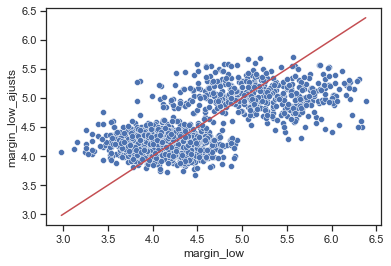

In [267]:
#Presenter de nuage de points, les margin_low_ajustés en fonction de margin_low 
df_billet_no['margin_low_ajusts'] = reg_multi.predict(df_billet_no[['diagonal','height_left','height_right','margin_up','length']])
X_plot = [df_billet_no['margin_low'].min(), df_billet_no['margin_low'].max()]
ax = sns.scatterplot(x="margin_low", y="margin_low_ajusts", data=df_billet_no)
ax.set(xlabel='margin_low', ylabel='margin_low_ajusts')
plt.plot(X_plot, X_plot, color='r')
plt.show()

## Les analyses de résultats
Après avoir estimé un modèle de régression linéaire, il faut ensuite analyser :
- La significativité des paramètres : Pour savoir quels sont les paramètres significatifs et donc détecter les variables qu'il faut intégrer (ou non) au modèle. Un modèle correct doit avoir des paramètres significatifs.
- L'atypicité et l'influence éventuelle de certaines données : on pourra retirer les données atypiques et influentes.
- Les éventuels problèmes de colinéarité.
- Les éventuels problèmes d'hétéroscédasticité (quand la variance des résidus ne peut pas être considérée comme constante).

### Sélectionner le modèle par procédure descendante ou backward

In [268]:
#Fonction de selection automatique du modele
def backward_selected(data, response):
        remaining = set(data._get_numeric_data().columns)
        if response in remaining:
            remaining.remove(response)
        cond = True
        while remaining and cond:
            formula = "{} ~ {} + 1".format(response,' + '.join(remaining))
            print('_______________________________')
            print(formula)
            model = smf.ols(formula, data).fit()
            score = model.pvalues[1:]
            toRemove = score[score == score.max()]
            if toRemove.values > 0.05:
                print('remove', toRemove.index[0], '(p-value :', round(toRemove.values[0],3), ')')
                remaining.remove(toRemove.index[0])
            else:
                cond = False
                print('is the final model !')
            print('')
        print(model.summary())
        return model

Certaines des variables obtenues ont des p-valeurs qui sont inférieures au niveau de test de 5 %, indiquant qu'elles sont bien significatives. Certaines autres ne sont pas en dessous de ce seuil donc on peut passer sur une procédure de sélection en retirant les variables non significatives au fur et à mesure.

In [269]:
#Appel du fonction reg_backward
columns = ['margin_low', 'diagonal','height_left', 'height_right', 'margin_up', 'length']
reg_backward = backward_selected(df_billet_no[columns], 'margin_low')

_______________________________
margin_low ~ diagonal + height_right + margin_up + height_left + length + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     261.5
Date:                Fri, 03 May 2024   Prob (F-statistic):          7.83e-199
Time:                        10:41:02   Log-Likelihood:                -936.71
No. Observations:                1440   AIC:                             1885.
Df Residuals:                    1434   BIC:                             1917.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]

Le modèle soit le plus parcimonieux possible en intégrant les variables qui sont réellement utiles.

### Utilisation des statsmodel

In [270]:
#Importer des librairies
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels

reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data = df_billet_no).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     261.5
Date:                Fri, 03 May 2024   Prob (F-statistic):          7.83e-199
Time:                        10:41:04   Log-Likelihood:                -936.71
No. Observations:                1440   AIC:                             1885.
Df Residuals:                    1434   BIC:                             1917.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       23.2668      9.531      2.441   

On constate que les paramètres sont significativement 0, car leur p-valeur est inférieure à 5 %.
- Le  𝑅2 vaut environ 0.477, et le  𝑅2 ajusté est d'environ 0.475.

### Calculer les leviers
L'analyse l'atypicité des observations sur les variables explicatives. Belsey a proposé de considérer l'observation i comme atypique si : leviers des observations(hii) > 2(p/n)

In [271]:
#Importer des packages des analyses statistiques
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [272]:
#Réaliser les tests à un niveau 𝛼 = 5%
alpha = 0.05

#Récupérons n, le nombre d'individus de l'échantillon et p, le nombre de variables.
n = df_billet_no.shape[0]
p = 4

In [273]:
#Analyser sur les valeurs atypiques et/ou influentes en travaillant sur un dataframe appelé 'analyses'
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})
analyses['obs'].astype('int64')

0          1
1          2
2          3
3          4
4          5
        ... 
1435    1436
1436    1437
1437    1438
1438    1439
1439    1440
Name: obs, Length: 1440, dtype: int64

In [274]:
#Calculer les leviers comme ceci, en sachant que le seuil des leviers est de 2∗pn
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag
seuil_levier = 2*p/n

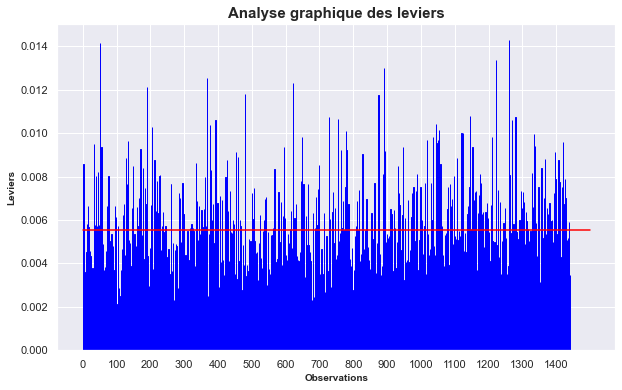

In [275]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,6))

#Le bar plot des observations influentes visualisant les leviers pour chaque point 
bars  = plt.bar(x=list(analyses['obs']), height=list(analyses['levier']))   

for bar in bars:                                                           
    bar.set_color('blue')                                                 
plt.plot([0, 1500], [seuil_levier, seuil_levier], color='red')

plt.xticks(np.arange(0, 1500, step=100))
plt.xlabel('Observations', fontsize=10, fontweight='bold')
plt.ylabel('Leviers', fontsize=10, fontweight='bold')
plt.title('Analyse graphique des leviers', fontsize=15, fontweight='bold')
plt.show()


In [276]:
#Sélectionner les points pour lesquels le levier est supérieur au seuil,
df_levier = analyses.loc[analyses['levier'] > seuil_levier, :]
df_levier

,obs,levier
0,1,0.00615
1,2,0.00858
3,4,0.00574
12,13,0.00581
15,16,0.00665
...,...,...
1424,1425,0.00676
1425,1426,0.00787
1426,1427,0.00579
1427,1428,0.00703


### Calculer les résidus studentisés
L'analyse l'atypicité des observation sur la variable à expliquer à partir des résidus. 
- Les résidus studentisés évalue si une observation est atypique. Une forte valeur de ces résidus caractérisera une observation atypique.

In [277]:
#Le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté 
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

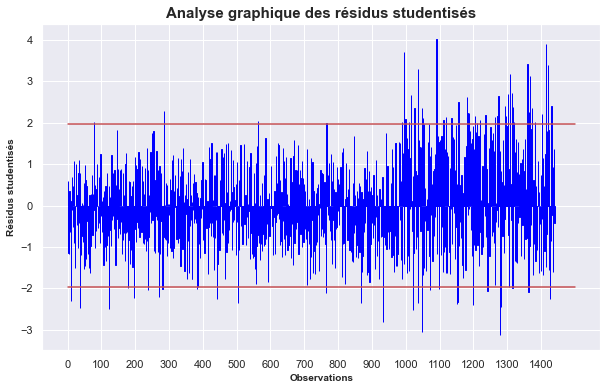

In [278]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,6))
bars  = plt.bar(x=list(analyses['obs']), height=list(analyses['rstudent']))   
for bar in bars:                                                           
    bar.set_color('blue')                                              
plt.xticks(np.arange(0, 1500, step=100))

plt.xlabel('Observations',fontsize=10, fontweight='bold')
plt.ylabel('Résidus studentisés',fontsize=10, fontweight='bold')
plt.plot([0, 1500], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1500], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.title('Analyse graphique des résidus studentisés', fontsize=15, fontweight='bold')
plt.show()

In [279]:
#Sélection des points pour lesquels le résidu studentisé est supérieur au seuil_rstudent
df_rstudent = analyses.loc[(analyses['rstudent'] > seuil_rstudent )| (analyses['rstudent'] < -seuil_rstudent) ]
df_rstudent

,obs,levier,rstudent
9,10,0.00208,-2.30136
36,37,0.00186,-2.47998
78,79,0.00505,2.01817
122,123,0.00672,-2.49664
178,179,0.00419,-1.99242
...,...,...,...
1401,1402,0.00434,2.21722
1414,1415,0.00155,3.89650
1419,1420,0.00961,3.40311
1426,1427,0.00579,-2.26102


En pratique, on ne retire que les observations atypiques et influentes. 

### Déterminer la distance de Cook

La mesure de l'influence d'une observation s'effectue à l'aide de la distance de Cook qui mesure un écart entre βˆ
 et βˆ(−i) (calculs effectués sans la i-ème observation)
- Cook a proposé de considérer l'observation i
 comme influente si : Di > (4/n−p)

In [280]:
#Détecter les observations influentes 
influence = reg_multi.get_influence().summary_frame()

In [281]:
#Le seuil de la distance de Cook est de n-p
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

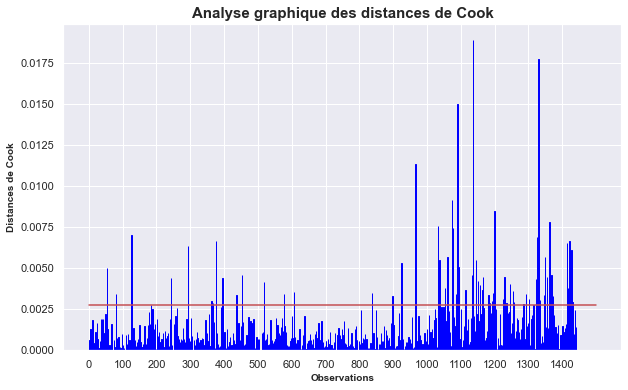

In [282]:
#Détecter les observations influentes 
sns.set_style("darkgrid")
plt.figure(figsize=(10,6))
bars  = plt.bar(x=list(analyses['obs']), height=list(analyses['dcooks']))   
for bar in bars:                                                           
    bar.set_color('blue') 

plt.xticks(np.arange(0, 1500, step=100))
plt.xlabel('Observations',fontsize=10, fontweight='bold')
plt.ylabel('Distances de Cook',fontsize=10, fontweight='bold')
plt.plot([0, 1500], [seuil_dcook, seuil_dcook], color='r')
plt.title('Analyse graphique des distances de Cook', fontsize=15, fontweight='bold')
plt.show()

In [283]:
#Sélection des points pour lesquels la distance de Cook est supérieur au seuil de Cook
df_dcooks = analyses.loc[analyses['dcooks'] > seuil_dcook, :]
df_dcooks

,obs,levier,rstudent,dcooks
52,53,0.00261,0.62565,0.00504
80,81,0.00271,0.50695,0.00344
125,126,0.00439,-0.38875,0.00703
243,244,0.00280,-0.14545,0.00442
292,293,0.00335,0.50578,0.00636
...,...,...,...,...
1418,1419,0.00458,0.68093,0.00429
1420,1421,0.00625,0.29139,0.00664
1422,1423,0.00658,-0.23963,0.00284
1426,1427,0.00579,-2.26102,0.00613


In [284]:
#Chercher les observations atypiques et influentes en faisant une jointure 'inner join'
df= pd.merge(pd. merge(df_levier,df_rstudent, on='obs'), df_dcooks, on='obs')
df

,obs,levier_x,levier_y,rstudent_x,levier,rstudent_y,dcooks
0,1090,0.00663,0.00663,2.02929,0.00663,2.02929,0.01496
1,1091,0.00695,0.00695,4.02420,0.00695,4.02420,0.00455
2,1373,0.00657,0.00657,2.35836,0.00657,2.35836,0.00332
3,1427,0.00579,0.00579,-2.26102,0.00579,-2.26102,0.00613


Il y a 4 observations qui sont atypiques et influentes

## Vérifier la colinéarité des variables
La mesure de la colinéarité examine les facteurs d'inflation de la variance (FIV) ou variance inflation factor (VIF) en anglais. 
- Les FIV estimenent de combien la variance d'un coefficient est augmentée en raison d'une relation linéaire avec d'autre prédicteurs. Il n'existe pas de test statistique qui permettrait de dire s'il y a une colinéarité ou non.

In [285]:
#Importer des librairies
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Choisir de DataFrame
df = df_billet_no[["diagonal","height_left","height_right","margin_low", "margin_up", "length"]]

X=df_billet_no[["diagonal","height_left","height_right", "margin_up", "length"]]
y=df_billet_no["margin_low"]

#Find design matrix for linear regression model using 'rating' as response variable
y, X = dmatrices('margin_low~diagonal+height_left+height_right+margin_up+length', data=df, return_type='dataframe')

#Calculer un VIF pour chaque variable explicatif
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#Regarder un VIF pour chaque variable explicatif
vif

,VIF,variable
0,"605,749.13741",Intercept
1,1.01278,diagonal
2,1.14061,height_left
3,1.22952,height_right
4,1.40523,margin_up
5,1.57936,length


Ici, tous les facteurs d'inflation de la variance (FIV) sont moins 2 donc il n'y a pas un problème de colinéarité entre une variable prédictive donnée et d’autres variables prédictives du modèle. Dans ce cas, les estimations des coefficients et les valeurs p dans les résultats de la régression sont probablement fiables.

### Tester l'Homoscedasticité (c'est-à-dire la constance de la variance) des résidus par un test de Breusch-Pagan
- On parle l’homoscédasticité lorsque la variance des erreurs des variables dans les modèles de régression est la même pour chaque observation.

In [286]:
#Importer des libraires 'statsmodels'
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan

variables = df_billet_no[["diagonal","height_left","height_right", "margin_up", "length"]]
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 5.812335601937203e-100


In [287]:
bp_test = het_breuschpagan(reg_multi.resid, variables)
labels = ['Statistique LM', 'p-value du test LM', 'Statistique F', 'p-value du test F']
results = lzip(labels, bp_test)
results

[('Statistique LM', 467.9158666066587),
 ('p-value du test LM', 5.812335601937203e-100),
 ('Statistique F', 138.14838562103307),
 ('p-value du test F', 9.621619908713324e-120)]

In [288]:
alpha=0.05
if pval > alpha:
    print("𝐻0 = les variances sont constantes (l'hypothèse d’homoscédasticité)")
else:
    print("𝐻1 = les variances ne sont pas constantes donc l'hétéroscédasticité")

𝐻1 = les variances ne sont pas constantes donc l'hétéroscédasticité


La p-valeur ici est inférieure à 5 %, on rejette l'hypothèse H0 selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité)

/var/folders/ff/46z7kp5x47l47x9jhyp0dd940000gn/T/ipykernel_62388/3978626175.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_billet_no['margin_low_ajusts'] = reg_multi.predict()
/var/folders/ff/46z7kp5x47l47x9jhyp0dd940000gn/T/ipykernel_62388/3978626175.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_billet_no['residus'] = reg_multi.resid


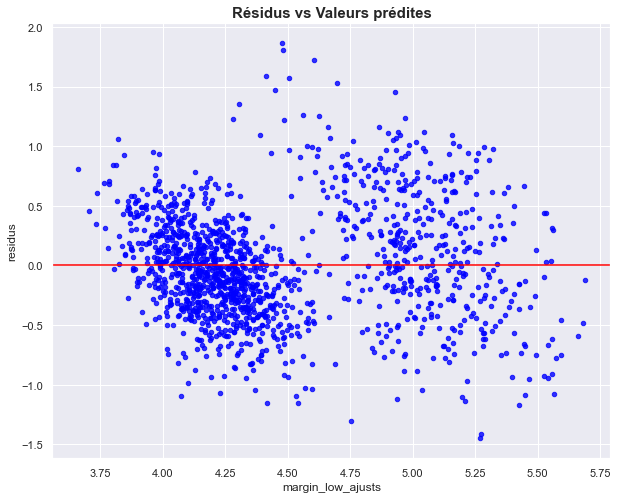

In [289]:
#Représenter le nuage de points avec les valeurs prédites comme abscisses et les résidus comme ordonnées.
df_billet_no['margin_low_ajusts'] = reg_multi.predict()
df_billet_no['residus'] = reg_multi.resid

#Le graphique
df_billet_no.plot(kind='scatter', x='margin_low_ajusts', y="residus", figsize=(10, 8), alpha=0.8, color='blue')
plt.title('Résidus vs Valeurs prédites',fontsize=15, fontweight='bold')
plt.axhline(y=0, color='red')
plt.show()

### Tester la normalité de residus 

In [290]:
#Tester la normalité de residus avec un test de Shapiro-Wilk
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9913812279701233, pvalue=1.8020855918621237e-07)

In [291]:
stat, p=shapiro(reg_multi.resid)
print('statistics = %.3f, p = %.3f' %(stat,p))

statistics = 0.991, p = 0.000


In [292]:
alpha=0.05
if p > alpha:
    print("H0 : Les résidus suivent une loi normale si p-value > 5%")
else:
    print("H1 : Les résidus ne suivent pas une loi normale si p-value < 5%")

H1 : Les résidus ne suivent pas une loi normale si p-value < 5%


In [293]:
#Représentez les résidus du modèle à l'aide de cette commande 
df_billet_no['residus'] = reg_multi.resid

/var/folders/ff/46z7kp5x47l47x9jhyp0dd940000gn/T/ipykernel_62388/1098603578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_billet_no['residus'] = reg_multi.resid


### Visualier de distribution de la normalité de résidus 

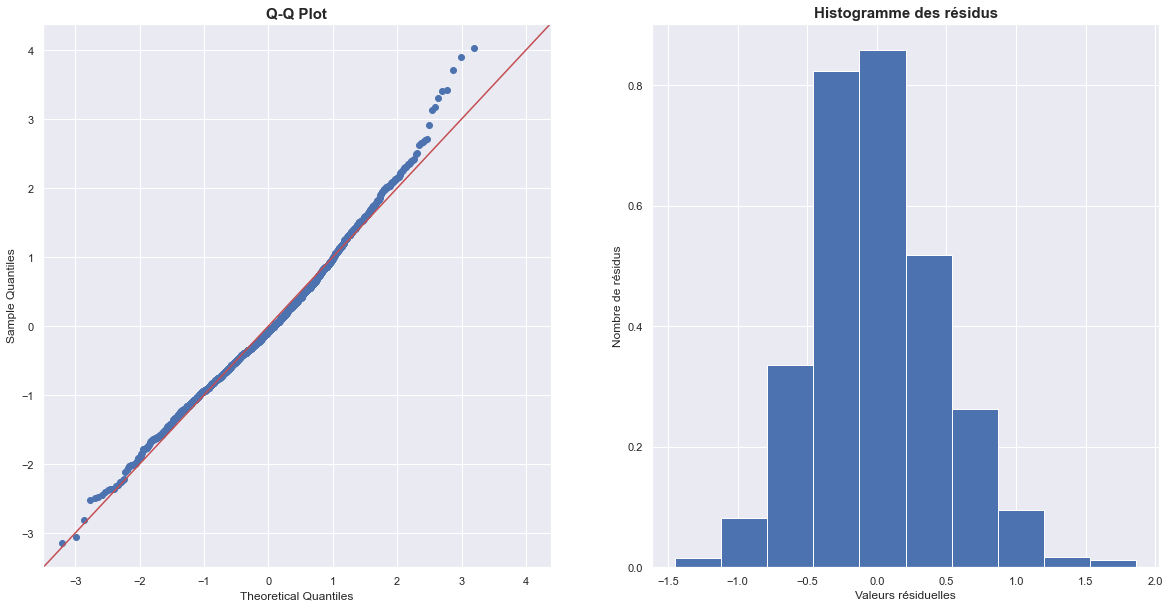

In [294]:
#Importer des librairies
import scipy.stats as stats
import statsmodels.api as sm

#Distribution des résidus
fig, ax = plt.subplots(1, 2, figsize=(20,10))

#Représentons l'histogramme des résidus du modèle
plt.hist(df_billet_no['residus'], density=True)
model_norm_residuals = reg_multi.get_influence().resid_studentized_internal

#create Q-Q plot with 45-degree line added to plot
QQ = sm.qqplot(model_norm_residuals,line='45', ax=ax[0])

ax[0].set_title('Q-Q Plot',fontsize=15, fontweight='bold')
ax[1].set_title('Histogramme des résidus', fontsize=15, fontweight='bold')
ax[1].set_xlabel('Valeurs résiduelles')
ax[1].set_ylabel('Nombre de résidus')
            
plt.show()

L'allure de l'histogramme est assez classique : centrée et à peu près symétrique.

### Tester Kolmogorov-Smirnov (loi Normale)

In [295]:
#Importer des librairies
from scipy import stats

X_ln2 =df_billet_no['residus']
Xbar_ln2 = np.mean(X_ln2)
Xsprime_ln2 = np.std(X_ln2)

ks_2samp(df_billet_no['residus'], list(np.random.normal(Xbar_ln2, Xsprime_ln2, 5_800_000)))

KstestResult(statistic=0.03817195402298845, pvalue=0.029320522689055384)

Avec les résultats précédents, l'hypothèse de normalité est remise en cause (p-value = 0.0 < 0.05),
Les résidus ne suivent pas totalement une loi Normale, mais les observations ne sont pas très différentes d'une distribution symétrique, et l'échantillon est de taille importante, les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes.

### Imputation des valeurs manquantes sur la variable margin_low à partir des résultats de la régression linéaire

In [296]:
#Afficher des 5 premières lignes de DataFrame des valeurs manquantes, df_billet_na
df_billet_na.head(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94000,103.89000,103.45000,NaN,3.25000,112.79000
99,True,171.93000,104.07000,104.18000,NaN,3.14000,113.08000
151,True,172.07000,103.80000,104.38000,NaN,3.02000,112.93000
197,True,171.45000,103.66000,103.80000,NaN,3.62000,113.27000
241,True,171.83000,104.14000,104.06000,NaN,3.02000,112.36000


In [297]:
#Enlever la colonne 'margin_low' du DataFrame 'df-billet_na'
df_billet_na1 = df_billet_na.drop(columns=['margin_low'], axis=1)
df_billet_na1.head(5)

,is_genuine,diagonal,height_left,height_right,margin_up,length
72,True,171.94000,103.89000,103.45000,3.25000,112.79000
99,True,171.93000,104.07000,104.18000,3.14000,113.08000
151,True,172.07000,103.80000,104.38000,3.02000,112.93000
197,True,171.45000,103.66000,103.80000,3.62000,113.27000
241,True,171.83000,104.14000,104.06000,3.02000,112.36000


In [298]:
#Afficher la DataFrame "df_billet_ml" qui contient des valeurs 'margin_low' 
df_billet_ml

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.46000,103.36000,103.66000,3.77000,2.99000,113.09000
1,True,172.69000,104.48000,103.50000,4.40000,2.94000,113.16000
2,True,171.36000,103.91000,103.94000,3.62000,3.01000,113.51000
3,True,171.73000,104.28000,103.46000,4.04000,3.48000,112.54000
4,True,172.17000,103.74000,104.08000,4.42000,2.95000,112.81000
...,...,...,...,...,...,...,...
1435,False,171.75000,104.38000,104.17000,4.42000,3.09000,111.28000
1436,False,172.19000,104.63000,104.44000,5.27000,3.37000,110.97000
1437,False,171.80000,104.01000,104.12000,5.51000,3.36000,111.95000
1438,False,172.06000,104.28000,104.06000,5.17000,3.46000,112.25000


In [299]:
#Vérifier des valeurs manquantes
df_billet_ml.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [300]:
#Les valeurs de X_train
X_train = df_billet_ml.drop(columns=['is_genuine','margin_low'], axis=1)

In [301]:
#Les valeurs de y_train
y_train = df_billet_ml['margin_low']

In [302]:
#Enlever des colonnes 'is_genuine' et 'margin_low'
X_test = df_billet_na.drop(columns=['is_genuine','margin_low'], axis=1)

In [303]:
#Importer des librairies
from sklearn.linear_model import LinearRegression
#Instancier
reg_multi=LinearRegression()
#Entraîner le modèle consiste à appliquer la méthode fit() sur le modèle
reg_multi.fit(X_train, y_train)

LinearRegression()

In [304]:
#Prévoir X_test
y_pred = reg_multi.predict(X_test)
y_pred

array([4.31791032, 4.3817409 , 4.38931628, 4.3202097 , 4.63262239,
       3.81132993, 4.17762718, 4.11838316, 4.13116069, 4.15728262,
       4.18357172, 3.76126949, 4.05251879, 4.29643898, 4.14978262,
       4.08097088, 4.42791513, 4.45664539, 4.33481961, 4.0779269 ,
       3.62429443, 4.35570676, 4.08782191, 4.24804518, 3.89232576,
       3.74512363, 4.23110508, 4.68554542, 4.13710986, 5.0233867 ,
       4.7861841 , 5.04035636, 5.02435756, 4.76258017, 5.6962048 ,
       5.15867494, 5.11208916])

In [305]:
#Créer une colonne 'margin_low' avec y_pred
df_billet_na1['margin_low'] = y_pred
df_billet_na1

,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low
72,True,171.94000,103.89000,103.45000,3.25000,112.79000,4.31791
99,True,171.93000,104.07000,104.18000,3.14000,113.08000,4.38174
151,True,172.07000,103.80000,104.38000,3.02000,112.93000,4.38932
197,True,171.45000,103.66000,103.80000,3.62000,113.27000,4.32021
241,True,171.83000,104.14000,104.06000,3.02000,112.36000,4.63262
251,True,171.80000,103.26000,102.82000,2.95000,113.22000,3.81133
284,True,171.92000,103.83000,103.76000,3.23000,113.29000,4.17763
334,True,171.85000,103.70000,103.96000,3.00000,113.36000,4.11838
410,True,172.56000,103.72000,103.51000,3.12000,112.95000,4.13116
413,True,172.30000,103.66000,103.50000,3.16000,112.95000,4.15728


In [306]:
#Créer un nouveau DataFrame 'billet_vmr' en concatenant de deux DataFrames
regression_result = [df_billet_ml,df_billet_na1]
billet_vmr = pd.concat(regression_result)
billet_vmr

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.46000,103.36000,103.66000,3.77000,2.99000,113.09000
1,True,172.69000,104.48000,103.50000,4.40000,2.94000,113.16000
2,True,171.36000,103.91000,103.94000,3.62000,3.01000,113.51000
3,True,171.73000,104.28000,103.46000,4.04000,3.48000,112.54000
4,True,172.17000,103.74000,104.08000,4.42000,2.95000,112.81000
...,...,...,...,...,...,...,...
1303,False,172.17000,104.49000,103.76000,5.02436,2.93000,111.21000
1315,False,172.08000,104.15000,104.17000,4.76258,3.40000,112.29000
1347,False,171.72000,104.46000,104.12000,5.69620,3.61000,110.31000
1435,False,172.66000,104.33000,104.41000,5.15867,3.56000,111.47000


## La régression logistique
La régression logistique est utilisée pour résoudre les problèmes de classification binaire avec deux classes possibles. On peut adapter la régression linéaire pour de la classification en appliquant la fonction logistique qui transforme la prédiction en une probabilité d'appartenance à une des classes. 

In [307]:
#Afficher un DataFrame 'billet_vmr' rempli avec des valeurs de 'margin_low'
billet_vmr

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.46000,103.36000,103.66000,3.77000,2.99000,113.09000
1,True,172.69000,104.48000,103.50000,4.40000,2.94000,113.16000
2,True,171.36000,103.91000,103.94000,3.62000,3.01000,113.51000
3,True,171.73000,104.28000,103.46000,4.04000,3.48000,112.54000
4,True,172.17000,103.74000,104.08000,4.42000,2.95000,112.81000
...,...,...,...,...,...,...,...
1303,False,172.17000,104.49000,103.76000,5.02436,2.93000,111.21000
1315,False,172.08000,104.15000,104.17000,4.76258,3.40000,112.29000
1347,False,171.72000,104.46000,104.12000,5.69620,3.61000,110.31000
1435,False,172.66000,104.33000,104.41000,5.15867,3.56000,111.47000


In [308]:
#Le pourcentage des valeurs de 'is_genuine : vrai' et 'faux'
billet_vmr['is_genuine'].value_counts(True)

True    0.67299
False   0.32701
Name: is_genuine, dtype: float64

In [309]:
#Séparation de dataset entre 'vrai' et 'faux'
faux_billet= billet_vmr.loc[billet_vmr['is_genuine'] ==False]
vrai_billet= billet_vmr.loc[billet_vmr['is_genuine'] ==True]
print(faux_billet.shape,vrai_billet.shape)

(483, 7) (994, 7)


In [310]:
#Compter des valeurs 'is_genuine' : 'vrai' et 'faux'
billet_vmr['is_genuine'].value_counts(False)

True     994
False    483
Name: is_genuine, dtype: int64

In [311]:
#Faire statistiques simple de 'vrai_billet' avec .describe
vrai_billet.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,994.00000,994.00000,994.00000,994.00000,994.00000,994.00000
mean,171.98627,103.94868,103.80807,4.11615,3.05253,113.20186
std,0.29694,0.29893,0.28838,0.31594,0.18477,0.35930
min,171.13000,103.14000,102.82000,2.98000,2.56000,111.76000
25%,171.79000,103.74000,103.61000,3.91000,2.93000,112.95250
50%,171.99000,103.95000,103.81000,4.11919,3.05000,113.20000
75%,172.20000,104.14000,104.00000,4.34000,3.18000,113.46000
max,172.76000,104.83000,104.76000,4.94000,3.74000,114.44000


In [312]:
#Faire statistiques simple de 'faux_billet' avec .describe
faux_billet.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,483.00000,483.00000,483.00000,483.00000,483.00000,483.00000
mean,171.90234,104.19178,104.14075,5.18284,3.35002,111.64503
std,0.29872,0.22456,0.26919,0.52070,0.17777,0.60150
min,171.05000,103.51000,103.43000,3.82000,2.92000,110.22000
25%,171.70500,104.04000,103.95000,4.82000,3.22500,111.21000
50%,171.91000,104.18000,104.16000,5.16000,3.35000,111.63000
75%,172.10000,104.34000,104.31500,5.58000,3.47000,112.03500
max,172.72000,104.88000,104.87000,6.38000,3.81000,113.85000


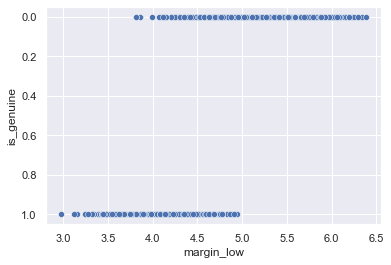

In [313]:
#Le graphique de nuage de points de 'margin_low' et 'is_genuine' 
sns.set()
ax = sns.scatterplot(x="margin_low", y="is_genuine", data=billet_vmr)

### Effectuez la régression logistique

In [314]:
#importer lse libraires nécessaires
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [315]:
#Changer le type des données de les colonnes
X=billet_vmr[['diagonal','height_left','height_right','margin_low','margin_up','length']]

In [316]:
#Encoder les catégories de la colonne en valeurs numériques pour attribue un code unique à chaque catégorie.
y=billet_vmr['is_genuine']
y

0        True
1        True
2        True
3        True
4        True
        ...  
1303    False
1315    False
1347    False
1435    False
1438    False
Name: is_genuine, Length: 1477, dtype: category
Categories (2, object): [False, True]

In [317]:
#Encoder les catégories de la colonne en valeurs numériques
y=y.cat.codes
y

0       1
1       1
2       1
3       1
4       1
       ..
1303    0
1315    0
1347    0
1435    0
1438    0
Length: 1477, dtype: int8

In [318]:
#Divisier le dataset en train et split 
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)
print('Train set:', X_train.shape,y_train.shape)#une partie d'entraînement (train)
print('Test set:', X_test.shape, y_test.shape)#une partie de test (test)

Train set: (1181, 6) (1181,)
Test set: (296, 6) (296,)


In [319]:
#Transformer les données suivant une distribution normale de moyenne =0 et écart-type =1
X=preprocessing.StandardScaler().fit_transform(X_train)
X

array([[-0.7248543 ,  0.43234464,  0.26462701, -0.45429477, -0.52610718,
         0.97849385],
       [ 1.31703311,  0.19876778, -0.50415312, -0.78379107, -0.95698969,
        -0.00178703],
       [ 0.07851124, -0.9357484 , -1.18067962, -1.08190677, -1.47404869,
        -0.20937593],
       ...,
       [ 1.28355954,  0.03192716,  0.8181487 , -0.01496636, -0.52610718,
         0.5171852 ],
       [ 1.48440093, -0.26838594, -0.3811483 , -0.63014083, -0.09522467,
         0.81703582],
       [-0.32317153,  0.13203153, -1.14992842,  0.17331724,  1.49904061,
        -0.73988087]])

In [320]:
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))
#Les données sont de type numpy array
#On va utiliser la fonction de Pandas .describe() pour vérifier la normalisation des données
pd.DataFrame(X).describe()

,0,1,2,3,4,5
count,"1,181.00","1,181.00","1,181.00","1,181.00","1,181.00","1,181.00"
mean,0.00,0.00,0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.60,-2.97,-2.96,-2.35,-2.55,-2.78
25%,-0.69,-0.74,-0.66,-0.69,-0.74,-0.74
50%,0.01,0.03,-0.01,-0.25,-0.05,0.32
75%,0.68,0.67,0.70,0.57,0.72,0.76
max,2.66,2.77,2.94,2.98,2.83,2.00


In [321]:
#Creation d'une modèle 
from sklearn.linear_model import LogisticRegression

#Créer une instance du modèle
LR = LogisticRegression(C = 0.04, solver ='liblinear')
#Entrainer le modèle
log_model = LR.fit(X_train, y_train)
log_model

LogisticRegression(C=0.04, solver='liblinear')

In [322]:
#Créer une fonction de score
def score(LR):
    """Calculer et afficher des train score et test score"""

    train_score = LR.score(X_train, y_train).round(4)
    test_score = LR.score(X_test, y_test).round(4)
    print(f"score train :{train_score} score test :{test_score}")

In [323]:
score(LR)

score train :0.9814 score test :0.9797


In [324]:
#Predire le test set 
y_pred = LR.predict(X_test)
print(y_pred)
print(y_test)

[0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1
 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0
 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0
 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0
 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1
 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0
 1 0 0 0 0 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1]
1233    0
529     1
1177    0
432     1
363     1
       ..
826     1
772     1
486     1
634     1
901     1
Length: 296, dtype: int8


In [325]:
#Etablir de probabilité de prédire X_test
y_proba = LR.predict_proba(X_test)
print(y_proba)

[[0.96529298 0.03470702]
 [0.05931661 0.94068339]
 [0.91515638 0.08484362]
 [0.0571631  0.9428369 ]
 [0.04696276 0.95303724]
 [0.09994589 0.90005411]
 [0.31972931 0.68027069]
 [0.96285301 0.03714699]
 [0.52848329 0.47151671]
 [0.9897181  0.0102819 ]
 [0.96701777 0.03298223]
 [0.85614093 0.14385907]
 [0.04131877 0.95868123]
 [0.13898901 0.86101099]
 [0.01120075 0.98879925]
 [0.7927624  0.2072376 ]
 [0.00859419 0.99140581]
 [0.0194841  0.9805159 ]
 [0.09329792 0.90670208]
 [0.70309455 0.29690545]
 [0.81823546 0.18176454]
 [0.04069088 0.95930912]
 [0.01009122 0.98990878]
 [0.64343762 0.35656238]
 [0.67672748 0.32327252]
 [0.0182993  0.9817007 ]
 [0.0250139  0.9749861 ]
 [0.10211517 0.89788483]
 [0.06392758 0.93607242]
 [0.03998784 0.96001216]
 [0.9733791  0.0266209 ]
 [0.4961652  0.5038348 ]
 [0.06254297 0.93745703]
 [0.10233708 0.89766292]
 [0.14588125 0.85411875]
 [0.85397242 0.14602758]
 [0.13693777 0.86306223]
 [0.03000315 0.96999685]
 [0.01920759 0.98079241]
 [0.06220696 0.93779304]


In [326]:
#Evaluation du training set
from sklearn.metrics import r2_score
y_train_predict = LR.predict(X_train)

rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = r2_score(y_train, y_train_predict)
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------')
print('Lerreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est  {}'.format(r2))

La performance du modèle sur la base dapprentissage
--------------------------------------
Lerreur quadratique moyenne est 0.13648546119531144
le score R2 est  0.9151048201589294


In [327]:
#Evaluation du testing set
y_test_predict = LR.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test,y_test_predict))
r2 = r2_score(y_test, y_test_predict )
print('la performance du modèle sur la base de test')
print('--------------------------------------')
print('Erreur quadratique moyenne est {}'.format(rmse))
print('le score R2 est {}'.format(r2))

la performance du modèle sur la base de test
--------------------------------------
Erreur quadratique moyenne est 0.14237369936287486
le score R2 est 0.9089370866020612


In [328]:
#Importer des librairies d'accuracy score
from sklearn import metrics
from sklearn.metrics import accuracy_score

accuracy = metrics.accuracy_score(y_test, y_pred) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 97.97%


In [329]:
#Déterminer la régression logistic avec GLM
reg_log = smf.glm('is_genuine~diagonal+height_left+height_right+margin_low+margin_up+length', data = billet_vmr, family=sm.families.Binomial()).fit()

print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1477
Model:                                                   GLM   Df Residuals:                     1470
Model Family:                                       Binomial   Df Model:                            6
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -41.934
Date:                                       Fri, 03 May 2024   Deviance:                       83.868
Time:                                               10:42:39   Pearson chi2:                 2.46e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7010
Covariance Type:                                   nonrobust                      

In [330]:
#Exclure les variables non significatives
reg_log1 = smf.glm('is_genuine~height_right+margin_low+margin_up+length', data = billet_vmr, family=sm.families.Binomial()).fit()

print(reg_log1.summary())


                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1477
Model:                                                   GLM   Df Residuals:                     1472
Model Family:                                       Binomial   Df Model:                            4
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -43.251
Date:                                       Fri, 03 May 2024   Deviance:                       86.502
Time:                                               10:42:55   Pearson chi2:                 3.14e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7005
Covariance Type:                                   nonrobust                      

En excluant les deux variables 'diagonal' et 'height_left' avec les p-valeurs > 5%, les paramètres du modèle ne s'améliorent pas significativement donc on les garde.

### Utilisation de Statsmodels

In [331]:
#Importer de librairie de StatsModels
import statsmodels.api as sm

#Statsmodels decide par defaut qu'il n'y a pas de constante, il faut ajouter donc une colonne
X=billet_vmr[['diagonal','height_left','height_right','margin_low','margin_up','length']]
X_stat = sm.add_constant(X)
print(X_stat)

      const  diagonal  height_left  height_right  margin_low  margin_up  \
0      1.00    171.46       103.36        103.66        3.77       2.99   
1      1.00    172.69       104.48        103.50        4.40       2.94   
2      1.00    171.36       103.91        103.94        3.62       3.01   
3      1.00    171.73       104.28        103.46        4.04       3.48   
4      1.00    172.17       103.74        104.08        4.42       2.95   
...     ...       ...          ...           ...         ...        ...   
1303   1.00    172.17       104.49        103.76        5.02       2.93   
1315   1.00    172.08       104.15        104.17        4.76       3.40   
1347   1.00    171.72       104.46        104.12        5.70       3.61   
1435   1.00    172.66       104.33        104.41        5.16       3.56   
1438   1.00    171.90       104.28        104.29        5.11       3.24   

      length  
0     113.09  
1     113.16  
2     113.51  
3     112.54  
4     112.81  
...      

In [332]:
#Ajuster le modèle, la classe logit attend en premier les variables nommées endogènes (qu'on désir)
#et ensuite les variables exogènes (qui expliquent y donc le x)
model = sm.Logit(y, X_stat)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.028391
         Iterations 13


In [333]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1477
Model:                          Logit   Df Residuals:                     1470
Method:                           MLE   Df Model:                            6
Date:                Fri, 03 May 2024   Pseudo R-squ.:                  0.9551
Time:                        10:42:57   Log-Likelihood:                -41.934
converged:                       True   LL-Null:                       -933.53
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -196.9652    254.774     -0.773      0.439    -696.314     302.383
diagonal         0.1708      1.138      0.150      0.881      -2.059       2.401
height_left     -1.7923      1.129     -1.587      0.112      -4.005       0.421
height_right    -2.3870      1.132     -2.108      0.035      -4.606      -0.168
margin_low      -5.7114      0.945     -6.041      0.000      -7.564      -3.858
margin_up       -9.9392      2.139     -4.647      0.000     -14.131      -5.747
length           5.8687      0.845      6.945      0.000       4.212       7.525
================================================================================

Possibly complete quasi-separation: A fraction 0.50 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

### Evaluer le modèle de régression logistique avec la matrice de confusion et le courbe ROC

### La matrice de confusion

Une matrice de confusion est un outil utile pour évaluer la performance d'un modèle de classification en comparant les valeurs réelles et les valeurs prédites. Elle permet de résumer les performances des modèles de classification. On peut calculer de nombreuses métriques telles que le rappel, la précision, le score f1 qui est utilisé pour évaluer les performances des modèles de classification.

In [334]:
#Importer des librairies de la confusion matrice et le score d'accuracy
import numpy as np
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import confusion_matrix as cm
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix

In [335]:
#Créer une confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
cm

array([[ 93,   6],
       [  0, 197]])

In [336]:
#Regardant directement le nombre de vrais positifs, vrais négatifs
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(93, 6, 0, 197)

In [337]:
#Afficher un DataFrame de confusion matrix
pd.DataFrame(confusion_matrix(y_test,y_pred))

,0,1
0,93,6
1,0,197


In [338]:
#Nommer les colonnes de DataFrame
mat = pd.DataFrame(confusion_matrix(y_test,y_pred))
mat.columns = [f"pred_{i}" for i in mat.columns]
mat.index = [f"test_{i}" for i in mat.index]
mat

,pred_0,pred_1
test_0,93,6
test_1,0,197


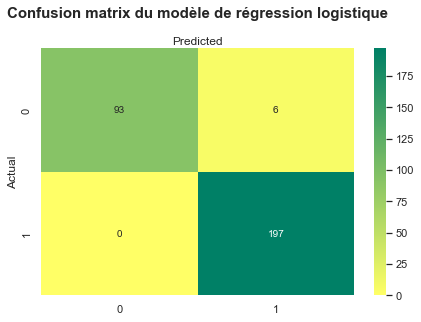

In [339]:
#Importer des libraires
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

classe=["Faux","Vrai"] 
fig, ax = plt.subplots()
tick_marks = np.arange(len(classe))#xticklabels=["Faux","Vrai"], yticklabels=["Faux","Vrai"]
xticklabels =["Faux","Vrai"]#(tick_marks, class_names)
yticklabels=["Faux","Vrai"]#(tick_marks, class_names)

#Créer un 'heatmap' de la confusion matrix
sns.heatmap(pd.DataFrame(cm), annot=True, cmap='summer_r' ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix du modèle de régression logistique', y=1.1, fontsize=15, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

La matrice de corrélation est généralement présentée sous forme de tableau avec des lignes et des colonnes qui correspondent aux valeurs réelles et aux valeurs prédites respectivement. Les valeurs dans chaque cellule de la matrice indiquent combien d'observations ont été classées de manière correcte ou incorrecte.
- La cellule en haut à gauche représente le nombre d'observations qui ont été classées comme appartenant à la classe 0 (faux billet) et qui sont réellement de la classe 0. Les observations qui ont été classées de manière correcte (93).
- La cellule en haut à droite représente le nombre d'observations qui ont été classées comme appartenant à la classe 0 mais qui sont réellement de la classe 1 (vrai billet). Les observations qui ont été classées de manière incorrecte (6).
- La cellule en bas à gauche représente le nombre d'observations qui ont été classées comme appartenant à la classe 1 mais qui sont réellement de la classe 0. Les observations qui ont été classées de manière incorrecte (0).
- La cellule en bas à droite représente le nombre d'observations qui ont été classées comme appartenant à la classe 1 (vrai billet), qui sont réellement de la classe 1. Les observations qui ont été classées de manière correcte (197).

In [340]:
#Importer des librairies
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9797297297297297
Precision: 0.9704433497536946
Recall: 1.0


pour calculer des metrics d'un modèle sur un ensemble de données de test, la fonction calcule ensuite la proportion de prédictions correctes et la renvoie sous forme de valeur flottante entre 0 et 1.
- L'accuracy est de 97,9% est la proportion de prédictions réellement positifs (vrais billets) parmi les prédits positifs.
- La précision de 97,04 est la proportion de prédictions correctes parmi les points que l’on a prédits positifs. Précision=TP/(TP+FP). La précision est adaptée quand on souhaite minimiser les faux positifs.
- Le rappel ("recall"  en anglais), ou sensibilité ("sensitivity" en anglais) de 100% est la proportion de positifs que l’on a correctement identifiés (Le taux de vrais positifs). Rappel=TP/(TP+FN). Le rappel est adapté pour minimiser les faux négatifs, quand les conséquences de manquer des instances positives sont graves.
- La spécificité ("specificity" en anglais) est le taux de vrais négatifs aussi une mesure complémentaire de la sensibilité. Spécificité = TN/(FP+TN)

In [341]:
#Importer des librairies
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = LR.predict(X_test)
print(y_pred)

#Calculer d'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

[0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1
 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1
 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0
 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0
 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0
 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1
 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0
 1 0 0 0 0 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1]
0.9797297297297297


La performance est assez bonne avec une précision de 97,9%.

In [342]:
#Afficher la classification rapporte
print(classification_report (y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        99
           1       0.97      1.00      0.98       197

    accuracy                           0.98       296
   macro avg       0.99      0.97      0.98       296
weighted avg       0.98      0.98      0.98       296



### La courbe ROC « Receiver-Operator Characteristic »

La courbe ROC « Receiver-Operator Characteristic » permet de visualiser comment la spécificité et la sensibilité d’un modèle évolue en fonction de ce seuil. Il permet de s'affranchir du seuil de classification pour mesurer la performance d'un modèle de classification

In [343]:
#Importer des librairies
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
#Calculer roc_auc
false_positive_rate, true_positive_rate, thresholds=roc_curve(y_test,y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate).round(2)
print(roc_auc)

0.97


La courbe ROC peut résumer par un nombre : "l'aire sous la courbe", aussi dénotée AUROC ou AUC pour «Area Under the ROC», est une mesure de la qualité de la classification qui varie entre :
- AUC=1/2 : dans le pire des cas
- AUC=1 : dans le meilleur des cas

Un classifieur parfait a une AUROC de 1; un classifieur aléatoire, une AUROC de 0.5

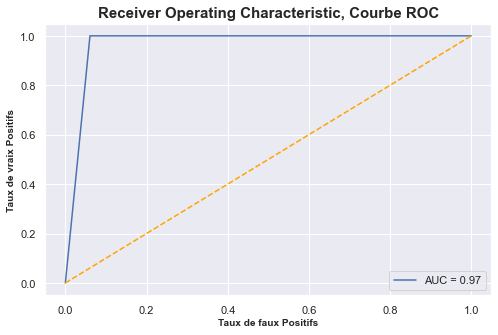

In [344]:
#Visualiser le courbe ROC 
plt.figure(figsize=(8,5))
plt.title ('Receiver Operating Characteristic, Courbe ROC',fontsize=15,fontweight='bold')
plt.plot(false_positive_rate, true_positive_rate, color = 'b', label = 'AUC = %0.2f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1], linestyle = '--', color='orange')
plt.axis('tight')
plt.ylabel('Taux de vraix Positifs', fontsize=10,fontweight='bold')
plt.xlabel('Taux de faux Positifs', fontsize=10,fontweight='bold')
plt.show()

Plus la courbe se rapproche du coin en haut à gauche, meilleur est le modèle

### Application du modèle des logistic régression aux données 'billets_production'

In [345]:
#Télécharger le donnes d'essai 'billets_production'
billet_prod = pd.read_csv("billets_production.csv", sep=',')
billet_prod

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [346]:
#Enlever la dernière colonne 'id'
X = billet_prod.iloc[:, :-1]
X

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.76,104.01,103.54,5.21,3.30,111.42
1,171.87,104.17,104.13,6.00,3.31,112.09
2,172.00,104.58,104.29,4.99,3.39,111.57
3,172.49,104.55,104.34,4.44,3.03,113.20
4,171.65,103.63,103.56,3.77,3.16,113.33


In [347]:
#Utilisation du modèle de prédiction 'LR'
y_pred = LR.predict(X)
y_pred

array([0, 0, 0, 1, 1], dtype=int8)

In [348]:
#Trouver des probabilités d'avoir 'vraie' ou 'faux' billets
probab = LR.predict_proba(X.values)[:, 1]
probab

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([0.12378322, 0.06979058, 0.07669603, 0.80199552, 0.98225644])

In [349]:
#Probabilités des billets établies 
probab = pd.Series(probab.round(3), name='value')
probab

0   0.12
1   0.07
2   0.08
3   0.80
4   0.98
Name: value, dtype: float64

In [350]:
df = pd.concat([billet_prod, probab], axis=1)
df

,diagonal,height_left,height_right,margin_low,margin_up,length,id,value
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.12
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.07
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.08
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.80
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,0.98


La classification de chaque billet donne la probabilité que un billet soit vrai ou faux. 
- La probabilité supérieure ou égale à 0.5 indique un billet vrai. 
- La probabilité inférieure à 0.5 est considéré comme un faux billet.

In [351]:
#Résultats de la classification prédictive :
resultat = []
for i in df['value'] >= 0.5:
    if i is True :
        resultat.append('Vrai Billet')
    else :
        resultat.append('Faux Billet')

df['classe de billet'] = resultat
df

,diagonal,height_left,height_right,margin_low,margin_up,length,id,value,classe de billet
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.12,Faux Billet
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.07,Faux Billet
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.08,Faux Billet
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,0.80,Vrai Billet
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,0.98,Vrai Billet


In [352]:
for i, k in zip(df['value'],df["id"]):
    if i > 0.5:
        print("Le billet","{}".format(k),"est vrai")
    else:
        print("Le billet","{}".format(k),"est faux")

Le billet A_1 est faux
Le billet A_2 est faux
Le billet A_3 est faux
Le billet A_4 est vrai
Le billet A_5 est vrai


### K-means
L'algorithme du k-means permet à calculer les centres des partitions d'échantillons, appelés "centroïdes" de façon itérative en minimisant la distance entre les points au sein d'une partition et maximise la distance entre les partitions jusqu'à ce que les centroïdes ne changent plus de manière significative, ou après un nombre d'itérations fixé à l'avance.

In [353]:
#Changer le type des données de les colonnes
X=billet_vmr[['diagonal','height_left','height_right','margin_low','margin_up','length']]

In [354]:
#Transformer les données suivant une distribution normale de moyenne =0 et écart-type =1
X=preprocessing.StandardScaler().fit_transform(X)
X

array([[-1.6632031 , -2.2330048 , -0.79680393, -1.0907107 , -0.69585803,
         0.46232852],
       [ 2.43793934,  1.50995382, -1.29314191, -0.10197554, -0.91357162,
         0.54379725],
       [-1.99662932, -0.39494476,  0.07178754, -1.32612383, -0.6087726 ,
         0.95114088],
       ...,
       [-0.79629494,  1.44311527,  0.63016777,  1.93231533,  2.00379048,
        -2.77314376],
       [ 2.33791148,  1.00866472,  1.52978037,  1.08870474,  1.78607689,
        -1.42309058],
       [-0.19612776,  0.84156835,  1.15752688,  1.01559205,  0.39270992,
        -1.3998138 ]])

In [355]:
#Encoder les catégories de la colonne en valeurs numériques pour attribue un code unique à chaque catégorie.
y=billet_vmr['is_genuine']
y

0        True
1        True
2        True
3        True
4        True
        ...  
1303    False
1315    False
1347    False
1435    False
1438    False
Name: is_genuine, Length: 1477, dtype: category
Categories (2, object): [False, True]

In [356]:
#Encoder les catégories de la colonne en valeurs numériques
y=y.cat.codes
y

0       1
1       1
2       1
3       1
4       1
       ..
1303    0
1315    0
1347    0
1435    0
1438    0
Length: 1477, dtype: int8

In [357]:
#Divisier le dataset en train et split 
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)
print('Train set:',X_train.shape,y_train.shape)#une partie d'entraînement (train)
print('Test set:', X_test.shape, y_test.shape)#une partie de test (test)

Train set: (1181, 6) (1181,)
Test set: (296, 6) (296,)


In [358]:
#Importer des librairies
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state = 42, init="k-means++")
kmeans.fit(X_train, y_train)
print(kmeans)

KMeans(n_clusters=2, random_state=42)


In [359]:
#Affichier des scores
train_score = kmeans.score(X_train, y_train)
test_score = kmeans.score(X_test, y_test)
print(f"score train : {train_score} score test : {test_score}")

score train : -4587.624580825997 score test : -1127.468676302045


In [360]:
print(kmeans.cluster_centers_)
print("score", kmeans.score(X_train,y_train))

[[-0.16787427  0.59514518  0.71090433  1.16538484  0.91327457 -1.23415051]
 [ 0.11760925 -0.27123921 -0.35057997 -0.51917061 -0.41856539  0.6005798 ]]
score -4587.624580825997


La méthode score du k-means mesure la distance entre les points et leur centroïde respectif en regroupant au maximum les points et donc cette distance doit être minimum.

In [361]:
y_pred = kmeans.predict(X_test)
y_pred

array([0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [362]:
r2 = r2_score(y_test, y_pred)
print(f"R2 score : {r2:.3f}")

R2 score : 0.970


In [363]:
#Calculer d'accuracy
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9932432432432432


In [364]:
#Importer des librairies de silhouette_score
from sklearn.metrics import silhouette_score

#Prédire X avec le modèle du kmeans
k_means_labels = kmeans.predict(X_test)
print("silhouette_score: ", silhouette_score(X_test,k_means_labels))

silhouette_score:  0.33326724812370917


Le coefficient de silhouette prend en compte la densité des clusters et l'écart entre les différents clusters. 
- Il se calcule à partir de la distance moyenne intra-groupe et de la distance moyenne entre les groupes les plus proches. 
- Le coefficient de silhouette est compris entre -1 (mauvais) et 1 (excellent).

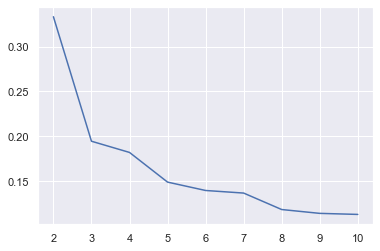

In [365]:
from sklearn.metrics import silhouette_score

scores = []
for n in range(2, 11, 1):
    km = KMeans( n_clusters=n, random_state = 42, n_init = 10, init= "k-means++")
    km.fit(X_train)
    labels_ = km.predict(X_test)
    scores.append(silhouette_score(X_test,labels_))

plt.plot(range(2, 11, 1), scores)
plt.show()

### Faire un graphique des nuages de points et leur répartition

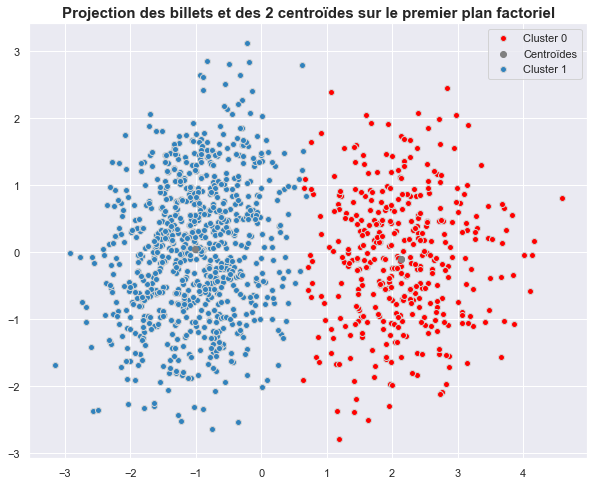

In [366]:
#Importer des relevantes librairies
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

#Options globales pour l'output display
pd.options.display.float_format = "{:.3f}".format

#Nombre de clusters
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_train,y_train)
KMeans(n_clusters = 2)

#Clustering par K-means
km = KMeans(n_clusters=2,random_state=42)
x_km = km.fit_transform(X_train,y_train)

#Ajouter d'une colonne contenant le cluster attribue:
clusters_km = km.labels_
centroids_km = km.cluster_centers_

#Clustering par projection des individus sur le premier plan factoriel
#Instancier l'ACP
pca = PCA()
pca_km = decomposition.PCA(n_components=2).fit(X_train,y_train)
acp_km = PCA(n_components=2).fit_transform(X_train,y_train)

centroids_km_projected = pca_km.transform(centroids_km)

#Le graphique:
plt.figure(figsize=(10, 8))
colormap = np.array(['red', 'blue'])
for couleur,k in zip(['red', "#3182bd"],[0,1]):
    plt.scatter(acp_km[km.labels_==k,0],acp_km[km.labels_==k,1],c=couleur,edgecolors="#D3D3D3",label="Cluster {}".format(k))
    plt.legend()
    plt.scatter(centroids_km_projected[:,0],centroids_km_projected[:,1],color="grey",label="Centroïdes")
plt.title("Projection des billets et des {} centroïdes sur le premier plan factoriel".format(len(centroids_km)),fontsize=15,fontweight='bold' )
plt.show()

### Evaluer l'algorithme du kmeans avec la matrice de confusion et le courbe ROC

### La Matrice de confusion du k-means

In [367]:
#Importer des librairies de la confusion matrice et le score d'accuracy
import numpy as np
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import confusion_matrix as cm
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix

In [368]:
#Créer une confusion matrix
conf_matrix = confusion_matrix(y_test,y_pred)
print(conf_matrix)

[[ 98   1]
 [  1 196]]


In [369]:
#Vous pouvez vous aider en regardant directement le nombre de vrais positifs, vrais négatifs, etc., avec :
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(98, 1, 1, 196)

In [370]:
#Nommer les colonnes de DataFrame 
mat = pd.DataFrame(conf_matrix)
mat.columns = [f"pred_ {i}" for i in mat.columns]
mat.index = [f"is_genuine {i}" for i in mat.index]
mat

,pred_ 0,pred_ 1
is_genuine 0,98,1
is_genuine 1,1,196


In [371]:
#Afficher la classification rapporte
print(classification_report (y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        99
           1       0.99      0.99      0.99       197

    accuracy                           0.99       296
   macro avg       0.99      0.99      0.99       296
weighted avg       0.99      0.99      0.99       296



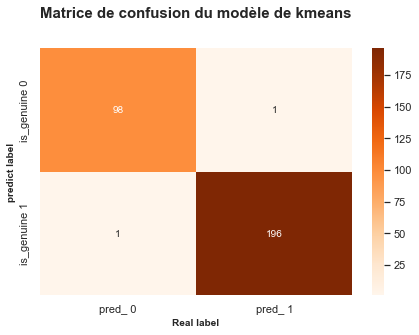

In [372]:
#Visualiser d'un 'Heatmap' de la matrice de confusion du kmeans 
sns.heatmap(mat, annot=True, cmap="Oranges" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matrice de confusion du modèle de kmeans', y=1.1, fontsize=15,fontweight='bold')
plt.ylabel('predict label', fontsize=10,fontweight='bold')
plt.xlabel('Real label', fontsize=10,fontweight='bold')
plt.show()

- La cellule en haut à gauche représente le nombre d'observations qui ont été classées comme appartenant à la classe 0 (faux billet) et qui sont réellement de la classe 0. Les observations qui ont été classées de manière correcte (98).
- La cellule en haut à droite représente le nombre d'observations qui ont été classées comme appartenant à la classe 0 mais qui sont réellement de la classe 1 (vrai billet). Les observations qui ont été classées de manière incorrecte (1).
- La cellule en bas à gauche représente le nombre d'observations qui ont été classées comme appartenant à la classe 1 mais qui sont réellement de la classe 0. Les observations qui ont été classées de manière incorrecte (1).
- La cellule en bas à droite représente le nombre d'observations qui ont été classées comme appartenant à la classe 1 (vrai billet), qui sont réellement de la classe 1. Les observations qui ont été classées de manière correcte (196).

In [373]:
#Regardez les scores de recall et de précision : 
import numpy as np
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9932432432432432
Precision: 0.9949238578680203
Recall: 0.9949238578680203


- L'accuracy est de 99,3% est la proportion de prédictions réellement positifs (vrais billets) parmi les prédits positifs.
- La précision de 99,5 est la proportion de prédictions correctes parmi les points que l’on a prédits positifs. Précision=TP/(TP+FP). La précision est adaptée quand on souhaite minimiser les faux positifs.
- Le rappel ("recall"  en anglais), ou sensibilité ("sensitivity" en anglais) de 99% est la proportion de positifs que l’on a correctement identifiés (Le taux de vrais positifs). Rappel=TP/(TP+FN). Le rappel est adapté pour minimiser les faux négatifs, quand les conséquences de manquer des instances positives sont graves.
- La spécificité ("specificity" en anglais) est le taux de vrais négatifs aussi une mesure complémentaire de la sensibilité. Spécificité = TN/(FP+TN)

In [374]:
#Trouver des centroids
centroids = centroids_km
pd.DataFrame(centroids, columns=billet_vmr[["diagonal","height_left","height_right","margin_low","margin_up","length"]].columns)

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.168,0.595,0.711,1.165,0.913,-1.234
1,0.118,-0.271,-0.351,-0.519,-0.419,0.601


### La courbe ROC « Receiver-Operator Characteristic »

In [375]:
#Importer des librairies
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
#Calculer roc_auc
false_positive_rate, true_positive_rate, thresholds=roc_curve(y_test,y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate).round(2)
print(roc_auc)

0.99


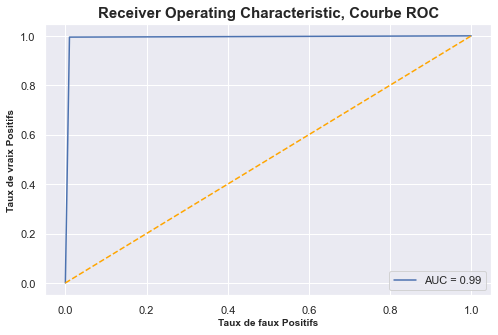

In [376]:
#Visualiser le courbe ROC 
plt.figure(figsize=(8,5))
plt.title ('Receiver Operating Characteristic, Courbe ROC',fontsize=15,fontweight='bold')
plt.plot(false_positive_rate, true_positive_rate, color = 'b', label = 'AUC = %0.2f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1], linestyle = '--', color='orange')
plt.axis('tight')
plt.ylabel('Taux de vraix Positifs', fontsize=10,fontweight='bold')
plt.xlabel('Taux de faux Positifs', fontsize=10,fontweight='bold')
plt.show()

### Application du modèle des kmeans aux données 'billets_production'

In [377]:
#Télécharger le donnes d'essai 'billets_production'
billet_prod = pd.read_csv("billets_production.csv", sep=',')
billet_prod

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.760,104.010,103.540,5.210,3.300,111.420,A_1
1,171.870,104.170,104.130,6.000,3.310,112.090,A_2
2,172.000,104.580,104.290,4.990,3.390,111.570,A_3
3,172.490,104.550,104.340,4.440,3.030,113.200,A_4
4,171.650,103.630,103.560,3.770,3.160,113.330,A_5


In [378]:
#Sélectionner des valeurs X
X = billet_prod.iloc[:,:-1]
X

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.760,104.010,103.540,5.210,3.300,111.420
1,171.870,104.170,104.130,6.000,3.310,112.090
2,172.000,104.580,104.290,4.990,3.390,111.570
3,172.490,104.550,104.340,4.440,3.030,113.200
4,171.650,103.630,103.560,3.770,3.160,113.330


In [379]:
#Sélectionner des valeurs y 
y= billet_prod['id']

In [380]:
#Utiliser kmeans à prédire X
kmeans.predict(X)
k_score=pd.Series(kmeans.predict(X))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [381]:
k_score=pd.Series(k_score.round(3), name='value')

In [382]:
km_predict_result= pd.concat([billet_prod, k_score], axis=1)
km_predict_result

,diagonal,height_left,height_right,margin_low,margin_up,length,id,value
0,171.760,104.010,103.540,5.210,3.300,111.420,A_1,0
1,171.870,104.170,104.130,6.000,3.310,112.090,A_2,0
2,172.000,104.580,104.290,4.990,3.390,111.570,A_3,0
3,172.490,104.550,104.340,4.440,3.030,113.200,A_4,0
4,171.650,103.630,103.560,3.770,3.160,113.330,A_5,0


In [383]:
#Résultats de la classification prédictive :
for i, k in zip(km_predict_result['value'],km_predict_result["id"]):
    if i >= 1 :
        print("Le billet","{}".format(k),"est vrai")
    else:
        print("Le billet","{}".format(k),"est faux")

Le billet A_1 est faux
Le billet A_2 est faux
Le billet A_3 est faux
Le billet A_4 est faux
Le billet A_5 est faux


### Conclusion

La prédiction par le modèle de la régression logistique est plus stable et performante que la prédiction par le modèle de kMeans.

### Enregistrement du modèle le plus performant

In [495]:
import joblib
from joblib import dump, load
dump(log_model, 'billetdetection.joblib')

['billetdetection.joblib']

### Application du modèle de la régression logistique aux données 'billets_test'

In [496]:
billet_test=pd.read_csv("billets_test.csv")
billet_test

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,172.090,103.950,103.730,4.390,3.090,113.190,B_1
1,171.520,104.170,104.030,5.270,3.160,111.820,B_2
2,171.780,103.800,103.750,3.810,3.240,113.390,B_3
3,172.020,104.080,103.990,5.570,3.300,111.100,B_4
4,171.790,104.340,104.370,5.000,3.070,111.870,B_5


In [497]:
#Données de test ou fichier à évaluer
billet_test = pd.read_csv("billets_test.csv")
X_test = billet_test[['diagonal','height_left','height_right','margin_low','margin_up','length']]


#chargement du modèle                                                                 
log_model = load('billetdetection.joblib')
  
y_pred = log_model.predict(X_test) 

billet_test["proba"] = log_model.predict(X_test)
billet_test["proba"]

0    1
1    0
2    1
3    0
4    0
Name: proba, dtype: int8

In [498]:
#Trouver des probabilités
probab = log_model.predict_proba(X_test)
probab

array([[0.08150042, 0.91849958],
       [0.84766195, 0.15233805],
       [0.02401367, 0.97598633],
       [0.97230902, 0.02769098],
       [0.83405008, 0.16594992]])

In [499]:
#Trouver des probabilités
probab = pd.Series(log_model.predict_proba(X_test)[:,1],name='value')
probab

0   0.918
1   0.152
2   0.976
3   0.028
4   0.166
Name: value, dtype: float64

In [500]:
df = pd.concat([billet_test,probab],axis=1)

In [501]:
df

,diagonal,height_left,height_right,margin_low,margin_up,length,id,proba,value
0,172.090,103.950,103.730,4.390,3.090,113.190,B_1,1,0.918
1,171.520,104.170,104.030,5.270,3.160,111.820,B_2,0,0.152
2,171.780,103.800,103.750,3.810,3.240,113.390,B_3,1,0.976
3,172.020,104.080,103.990,5.570,3.300,111.100,B_4,0,0.028
4,171.790,104.340,104.370,5.000,3.070,111.870,B_5,0,0.166


In [502]:
billet_test["pred"] = (log_model.predict(X_test) >= 0.5).astype(int)

# Affichage des resultats:
print("\nIndetification des billets:\n")
for i, k in zip(billet_test["pred"],billet_test["id"]):
    if i == 1:
        print("Le billet","{}".format(k),"est vrai")
    else:
        print("Le billet","{}".format(k),"est faux")


Indetification des billets:

Le billet B_1 est vrai
Le billet B_2 est faux
Le billet B_3 est vrai
Le billet B_4 est faux
Le billet B_5 est faux


In [503]:
#Résultats de la classification prédictive :
resultat = []
for i in df['value'] >= 0.5:
    if i is True :
        resultat.append('Vrai Billet')
    else :
        resultat.append('Faux Billet')

df['classe de billet'] = resultat
df

,diagonal,height_left,height_right,margin_low,margin_up,length,id,proba,value,classe de billet
0,172.090,103.950,103.730,4.390,3.090,113.190,B_1,1,0.918,Vrai Billet
1,171.520,104.170,104.030,5.270,3.160,111.820,B_2,0,0.152,Faux Billet
2,171.780,103.800,103.750,3.810,3.240,113.390,B_3,1,0.976,Vrai Billet
3,172.020,104.080,103.990,5.570,3.300,111.100,B_4,0,0.028,Faux Billet
4,171.790,104.340,104.370,5.000,3.070,111.870,B_5,0,0.166,Faux Billet
